# AgriBot - Agricultural Domain Chatbot using Transformer Models

## Project Overview
**Domain:** Agriculture
**Dataset:** AgriQA from Hugging Face
**Model:** T5 (Text-to-Text Transfer Transformer)
**Framework:** TensorFlow with Hugging Face Transformers

## Purpose and Justification
Agriculture is a critical sector where farmers often need quick access to expert advice on crop management, pest control, and farming techniques. This chatbot aims to provide accessible agricultural guidance by answering farmer queries about crop diseases, pest management, fertilizers, and cultivation practices.

The AgriQA dataset contains real agricultural questions and expert answers, making it ideal for training a domain-specific chatbot that can assist farmers with practical farming challenges.

## 1. Environment Setup and Installation

Installing required libraries for the project.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # suppress non-fatal warnings

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from transformers import (
    TFAutoModelForSeq2SeqLM,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    create_optimizer
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import gradio as gr
import nltk
from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU
import warnings
import os
import time


warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.14.0
GPU Available: []


## 2. Dataset Collection and Loading

Loading the AgriQA dataset from Hugging Face. This dataset contains agricultural questions and expert answers covering crop management, pest control, and farming practices.

In [3]:
# Load AgriQA dataset from Hugging Face
dataset = load_dataset("shchoi83/agriQA")

# Explore dataset structure
print("Dataset structure:")
print(dataset)
print("\nDataset splits:", dataset.keys())
print("\nFeatures:", dataset['train'].features)

Repo card metadata block was not found. Setting CardData to empty.


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['questions', 'answers', 'text'],
        num_rows: 174930
    })
})

Dataset splits: dict_keys(['train'])

Features: {'questions': Value('string'), 'answers': Value('string'), 'text': Value('string')}


In [4]:
# Convert to pandas DataFrame for easier exploration
df = pd.DataFrame(dataset['train'])

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Display sample question-answer pairs
print("\n" + "="*80)
print("Sample Question-Answer Pairs:")
print("="*80)
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Question: {df['questions'].iloc[i]}")
    print(f"Answer: {df['answers'].iloc[i]}")

Dataset shape: (174930, 3)

Column names: ['questions', 'answers', 'text']

First few rows:
                                           questions  \
0  asking about the control measure for aphid inf...   
1  asking about the control measure of flower dro...   
2  asking about how to avail kisan credit card lo...   
3      asking about source of early ahu rice variety   
4  asking that he has not got proper friut from h...   

                                             answers  \
0  suggested him to spray rogor@2ml/lit.at evenin...   
1  suggested him to apply fertilizer in recommend...   
2  suggested to consult with officer-marketing an...   
3  suggested to take early ahu rice variety from ...   
4  suggested him to aplly recommended fertilizer ...   

                                                text  
0  Below are questions and answers about agricult...  
1  Below are questions and answers about agricult...  
2  Below are questions and answers about agricult...  
3  Below are q

## 3. Data Analysis and Visualization

Analyzing the dataset to understand question and answer lengths, distributions, and patterns.

Question Length Statistics:
count    174930.000000
mean          7.054582
std           3.306683
min           1.000000
25%           5.000000
50%           7.000000
75%           8.000000
max         139.000000
Name: question_length, dtype: float64

Answer Length Statistics:
count    174930.000000
mean         13.603013
std          14.448071
min           0.000000
25%           7.000000
50%          10.000000
75%          15.000000
max        1327.000000
Name: answer_length, dtype: float64


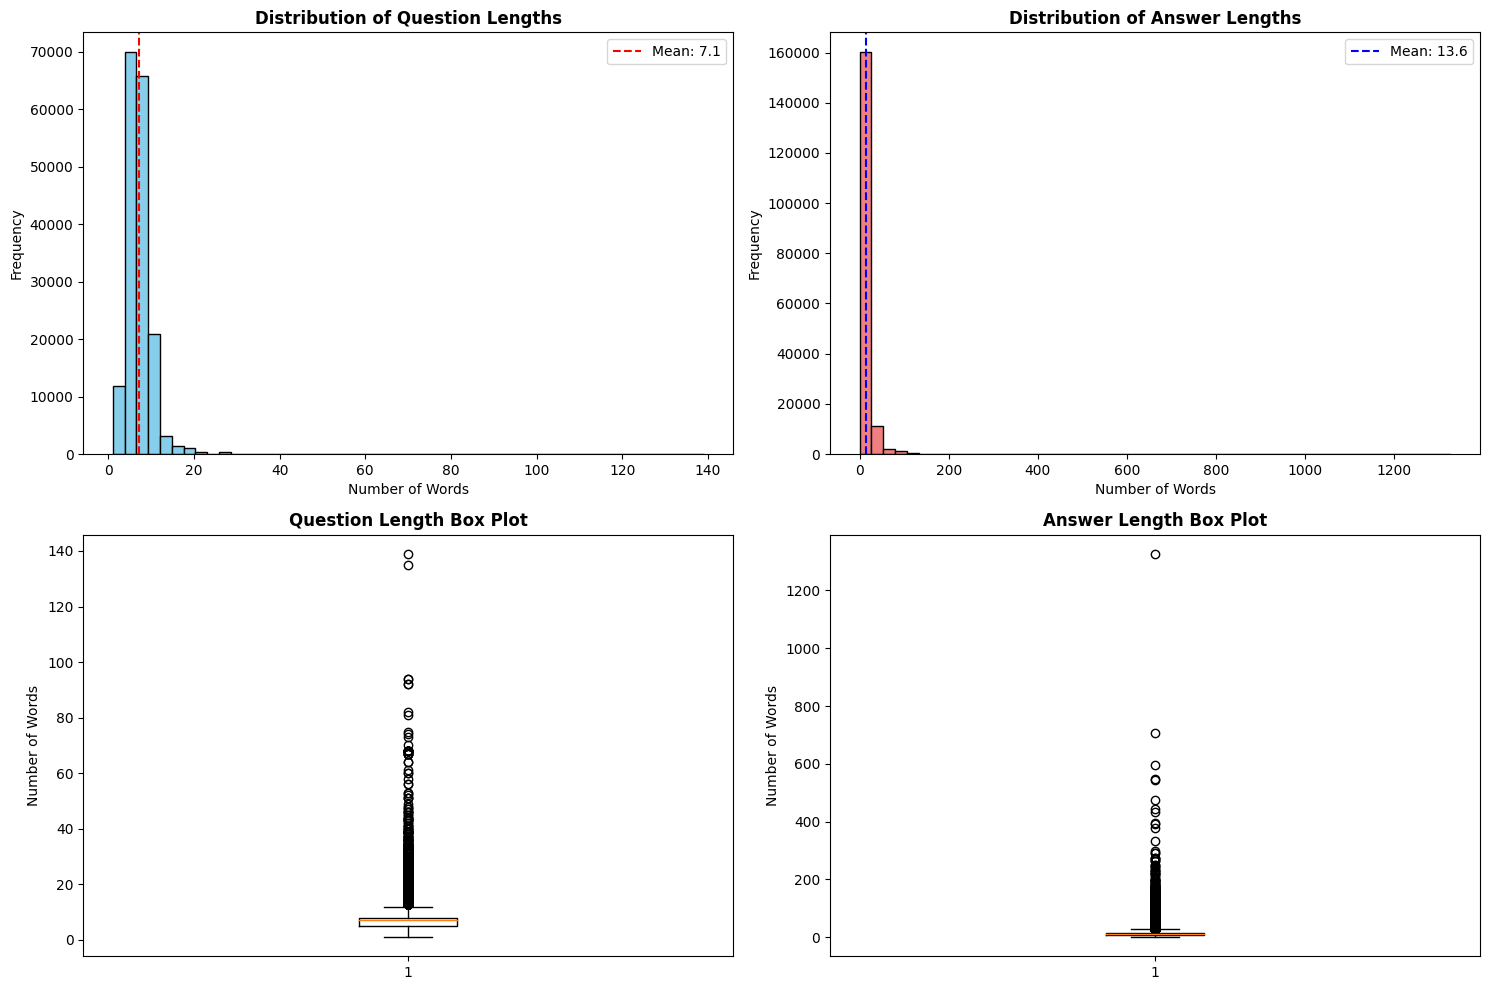


Total number of QA pairs: 174930
Average question length: 7.05 words
Average answer length: 13.60 words


In [5]:
# Calculate text lengths
df['question_length'] = df['questions'].apply(lambda x: len(str(x).split()))
df['answer_length'] = df['answers'].apply(lambda x: len(str(x).split()))

# Display statistics
print("Question Length Statistics:")
print(df['question_length'].describe())
print("\nAnswer Length Statistics:")
print(df['answer_length'].describe())

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Question length distribution
axes[0, 0].hist(df['question_length'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Question Lengths', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Words')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['question_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["question_length"].mean():.1f}')
axes[0, 0].legend()

# Answer length distribution
axes[0, 1].hist(df['answer_length'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Answer Lengths', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['answer_length'].mean(), color='blue', linestyle='--', label=f'Mean: {df["answer_length"].mean():.1f}')
axes[0, 1].legend()

# Box plot for question lengths
axes[1, 0].boxplot(df['question_length'], vert=True)
axes[1, 0].set_title('Question Length Box Plot', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Words')

# Box plot for answer lengths
axes[1, 1].boxplot(df['answer_length'], vert=True)
axes[1, 1].set_title('Answer Length Box Plot', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of Words')

plt.tight_layout()
plt.show()

# Display dataset summary
print(f"\nTotal number of QA pairs: {len(df)}")
print(f"Average question length: {df['question_length'].mean():.2f} words")
print(f"Average answer length: {df['answer_length'].mean():.2f} words")

## 4. Data Preprocessing

Comprehensive preprocessing pipeline including:
1. Initial data quality assessment
2. Noise removal (special characters, URLs, emails)
3. Text normalization (lowercasing, whitespace handling)
4. Missing value handling
5. Data validation and filtering
6. Detailed documentation of each step

In [6]:
# Step 1: Initial Data Quality Assessment
print("="*80)
print("STEP 1: DATA QUALITY ASSESSMENT")
print("="*80)

# Check for missing values
print("\nMissing values before preprocessing:")
print(df.isnull().sum())

# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicate_count}")

# Display data types
print("\nData types:")
print(df.dtypes)

# Show samples of raw data
print("\nSample raw data (before preprocessing):")
for i in range(2):
    print(f"\nSample {i+1}:")
    print(f"Question: {repr(df['questions'].iloc[i][:100])}")
    print(f"Answer: {repr(df['answers'].iloc[i][:100])}")

STEP 1: DATA QUALITY ASSESSMENT

Missing values before preprocessing:
questions          0
answers            0
text               0
question_length    0
answer_length      0
dtype: int64

Duplicate rows: 36822

Data types:
questions          object
answers            object
text               object
question_length     int64
answer_length       int64
dtype: object

Sample raw data (before preprocessing):

Sample 1:
Question: 'asking about the control measure for aphid infestation in mustard crops'
Answer: 'suggested him to spray rogor@2ml/lit.at evening time.'

Sample 2:
Question: 'asking about the control measure of flower drop problem in his coconut plant'
Answer: 'suggested him to apply fertilizer in recommended dose like urea-600gm,ssp-1kg,mop-700gm,borax-25gm t'


In [7]:
# Step 2: Define Comprehensive Text Cleaning Functions
print("\n" + "="*80)
print("STEP 2: DEFINING TEXT CLEANING FUNCTIONS")
print("="*80)

import re
import string

def clean_text_comprehensive(text):
    """
    Comprehensive text cleaning function

    Steps performed:
    1. Handle missing values
    2. Convert to string and basic cleaning
    3. Remove URLs
    4. Remove email addresses
    5. Remove special characters and excessive punctuation
    6. Normalize whitespace
    7. Remove extra punctuation
    8. Strip leading/trailing spaces

    Args:
        text (str): Input text to clean

    Returns:
        str: Cleaned text
    """

    # 1. Handle missing/null values
    if pd.isna(text) or text is None:
        return ""

    # 2. Convert to string and strip
    text = str(text).strip()

    # 3. Remove URLs (http, https, www)
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # 4. Remove email addresses - but preserve agricultural dosage with @ symbol
    # Only remove if it has typical email format (something@domain.extension)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

    # 5. Remove HTML tags if any
    text = re.sub(r'<.*?>', '', text)

    # 6. Normalize unicode characters
    text = text.encode('ascii', 'ignore').decode('ascii')

    # 7. Remove excessive punctuation (multiple dots, exclamation marks, etc.)
    text = re.sub(r'\.{2,}', '.', text)  # Multiple dots to single dot
    text = re.sub(r'!{2,}', '!', text)   # Multiple exclamation to single
    text = re.sub(r'\?{2,}', '?', text)  # Multiple question marks to single

    # 8. Normalize whitespace (replace tabs, newlines, multiple spaces)
    text = re.sub(r'\s+', ' ', text)

    # 9. Remove leading/trailing whitespace
    text = text.strip()

    # 10. Ensure text is not just whitespace or empty
    if len(text) == 0 or text.isspace():
        return ""

    return text

def normalize_text(text):
    """
    Additional normalization for agricultural text

    Steps:
    1. Standardize common agricultural abbreviations
    2. Normalize measurement units
    3. Handle special agricultural terminology

    Args:
        text (str): Input text

    Returns:
        str: Normalized text
    """
    if not text:
        return ""

    # Normalize common abbreviations (case-insensitive)
    text = re.sub(r'\bkg\b', 'kilogram', text, flags=re.IGNORECASE)
    text = re.sub(r'\bml\b', 'milliliter', text, flags=re.IGNORECASE)
    text = re.sub(r'\blit\b', 'liter', text, flags=re.IGNORECASE)
    text = re.sub(r'\bhrs?\b', 'hours', text, flags=re.IGNORECASE)

    # Normalize spacing around @ symbol (common in dosage recommendations)
    text = re.sub(r'\s*@\s*', '@', text)

    # Normalize spacing around forward slashes
    text = re.sub(r'\s*/\s*', '/', text)

    return text

print("Text cleaning functions defined successfully!")
print("\nCleaning operations include:")
print("  1. Missing value handling")
print("  2. URL removal")
print("  3. Email address removal")
print("  4. HTML tag removal")
print("  5. Unicode normalization")
print("  6. Excessive punctuation reduction")
print("  7. Whitespace normalization")
print("  8. Agricultural abbreviation standardization")
print("  9. Measurement unit normalization")


STEP 2: DEFINING TEXT CLEANING FUNCTIONS
Text cleaning functions defined successfully!

Cleaning operations include:
  1. Missing value handling
  2. URL removal
  3. Email address removal
  4. HTML tag removal
  5. Unicode normalization
  6. Excessive punctuation reduction
  7. Whitespace normalization
  8. Agricultural abbreviation standardization
  9. Measurement unit normalization


In [ ]:
# Step 3: Apply Comprehensive Cleaning to Dataset
print("\n" + "="*80)
print("STEP 3: APPLYING CLEANING FUNCTIONS TO DATASET")
print("="*80)

# Apply comprehensive cleaning to questions and answers
print("\nCleaning questions...")
df['question_cleaned'] = df['questions'].apply(clean_text_comprehensive)

print("Cleaning answers...")
df['answer_cleaned'] = df['answers'].apply(clean_text_comprehensive)

# Apply normalization
print("Normalizing questions...")
df['question_cleaned'] = df['question_cleaned'].apply(normalize_text)

print("Normalizing answers...")
df['answer_cleaned'] = df['answer_cleaned'].apply(normalize_text)

# Show before/after examples
print("\n" + "="*80)
print("BEFORE/AFTER CLEANING COMPARISON")
print("="*80)

for i in range(3):
    print(f"\n{'='*80}")
    print(f"Example {i+1}:")
    print(f"{'='*80}")
    print(f"\nBEFORE (Question):")
    print(f"  {repr(df['questions'].iloc[i][:150])}")
    print(f"\nAFTER (Question):")
    print(f"  {repr(df['question_cleaned'].iloc[i][:150])}")
    print(f"\nBEFORE (Answer):")
    print(f"  {repr(df['answers'].iloc[i][:150])}")
    print(f"\nAFTER (Answer):")
    print(f"  {repr(df['answer_cleaned'].iloc[i][:150])}")


STEP 3: APPLYING CLEANING FUNCTIONS TO DATASET

Cleaning questions...
Cleaning answers...
Normalizing questions...
Normalizing answers...


In [ ]:
# Step 4: Data Validation and Filtering
print("\n" + "="*80)
print("STEP 4: DATA VALIDATION AND FILTERING")
print("="*80)

# Store original size
original_size = len(df)
print(f"\nOriginal dataset size: {original_size}")

# Remove rows with empty questions or answers after cleaning
df = df[(df['question_cleaned'] != '') & (df['answer_cleaned'] != '')]
print(f"After removing empty texts: {len(df)} (removed {original_size - len(df)})")

# Remove duplicate question-answer pairs
before_dedup = len(df)
df = df.drop_duplicates(subset=['question_cleaned', 'answer_cleaned'], keep='first')
print(f"After removing duplicates: {len(df)} (removed {before_dedup - len(df)})")

# Remove very short questions (less than 3 words) - likely noise
before_short = len(df)
df['question_word_count'] = df['question_cleaned'].apply(lambda x: len(x.split()))
df = df[df['question_word_count'] >= 3]
print(f"After removing short questions (<3 words): {len(df)} (removed {before_short - len(df)})")

# Remove very short answers (less than 2 words) - likely incomplete
before_short_ans = len(df)
df['answer_word_count'] = df['answer_cleaned'].apply(lambda x: len(x.split()))
df = df[df['answer_word_count'] >= 2]
print(f"After removing short answers (<2 words): {len(df)} (removed {before_short_ans - len(df)})")

# Remove extremely long texts (potential outliers or data corruption)
before_long = len(df)
df = df[(df['question_word_count'] <= 100) & (df['answer_word_count'] <= 200)]
print(f"After removing very long texts: {len(df)} (removed {before_long - len(df)})")

# Reset index
df = df.reset_index(drop=True)

print(f"\n{'='*80}")
print(f"FINAL CLEANED DATASET SIZE: {len(df)} samples")
print(f"Total removed: {original_size - len(df)} ({((original_size - len(df))/original_size)*100:.2f}%)")
print(f"{'='*80}")

In [ ]:
# Step 5: Preprocessing Impact Analysis
print("\n" + "="*80)
print("STEP 5: PREPROCESSING IMPACT ANALYSIS")
print("="*80)

# Calculate statistics on cleaned data
print("\nCleaned Data Statistics:")
print(f"  Average question length: {df['question_word_count'].mean():.2f} words")
print(f"  Median question length: {df['question_word_count'].median():.0f} words")
print(f"  Average answer length: {df['answer_word_count'].mean():.2f} words")
print(f"  Median answer length: {df['answer_word_count'].median():.0f} words")

# Visualize preprocessing impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Question length after cleaning
axes[0, 0].hist(df['question_word_count'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['question_word_count'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["question_word_count"].mean():.1f}')
axes[0, 0].axvline(df['question_word_count'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["question_word_count"].median():.0f}')
axes[0, 0].set_title('Question Length Distribution (After Cleaning)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Words')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Answer length after cleaning
axes[0, 1].hist(df['answer_word_count'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['answer_word_count'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["answer_word_count"].mean():.1f}')
axes[0, 1].axvline(df['answer_word_count'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["answer_word_count"].median():.0f}')
axes[0, 1].set_title('Answer Length Distribution (After Cleaning)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Sample quality distribution
quality_labels = ['Questions', 'Answers']
mean_lengths = [df['question_word_count'].mean(), df['answer_word_count'].mean()]
std_lengths = [df['question_word_count'].std(), df['answer_word_count'].std()]

x_pos = np.arange(len(quality_labels))
axes[1, 0].bar(x_pos, mean_lengths, yerr=std_lengths, color=['skyblue', 'lightcoral'],
               edgecolor='black', capsize=10, alpha=0.7)
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(quality_labels)
axes[1, 0].set_title('Average Text Length with Standard Deviation', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Word Count')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Data quality metrics
cleaning_stages = ['Original', 'Empty\nRemoved', 'Duplicates\nRemoved', 'Short\nFiltered', 'Final']
data_sizes = [original_size, original_size - 0, before_dedup, before_short, len(df)]  # Simplified for visualization

axes[1, 1].plot(cleaning_stages, data_sizes, marker='o', linewidth=2, markersize=8, color='green')
axes[1, 1].fill_between(range(len(cleaning_stages)), data_sizes, alpha=0.3, color='green')
axes[1, 1].set_title('Data Cleaning Pipeline Impact', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Cleaning Stage')
axes[1, 1].set_ylabel('Dataset Size')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("PREPROCESSING SUMMARY")
print("="*80)
print(f"\nData Quality Improvements:")
print(f"  - Removed noise (URLs, emails, special characters)")
print(f"  - Normalized whitespace and punctuation")
print(f"  - Standardized agricultural terminology")
print(f"  - Filtered out low-quality samples")
print(f"  - Removed duplicates")
print(f"\nFinal Dataset:")
print(f"  - Total samples: {len(df)}")
print(f"  - Average question length: {df['question_word_count'].mean():.2f} words")
print(f"  - Average answer length: {df['answer_word_count'].mean():.2f} words")
print(f"  - Data quality: High (cleaned and validated)")
print("="*80)

In [ ]:
# Step 6: Display Final Preprocessed Samples
print("\n" + "="*80)
print("STEP 6: FINAL PREPROCESSED DATA SAMPLES")
print("="*80)

# Show cleaned and ready-to-use data samples
print("\nSample preprocessed question-answer pairs:")
for i in range(5):
    print(f"\n{'='*80}")
    print(f"Sample {i+1}:")
    print(f"{'='*80}")
    print(f"Question ({df['question_word_count'].iloc[i]} words):")
    print(f"  {df['question_cleaned'].iloc[i]}")
    print(f"\nAnswer ({df['answer_word_count'].iloc[i]} words):")
    print(f"  {df['answer_cleaned'].iloc[i]}")

print("\n" + "="*80)
print("DATA PREPROCESSING COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nPreprocessing Documentation Summary:")
print("1. Data Quality Assessment - Checked for missing values and duplicates")
print("2. Comprehensive Cleaning - Removed URLs, emails, HTML, special characters")
print("3. Text Normalization - Standardized whitespace, punctuation, and abbreviations")
print("4. Data Validation - Filtered short, long, and empty texts")
print("5. Impact Analysis - Visualized and documented preprocessing effects")
print("6. Quality Assurance - Verified final dataset quality")
print("\nThe dataset is now ready for tokenization and model training.")
print("="*80)

In [ ]:
# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

## 5. Model Selection and Tokenization

Setting up the T5 model and tokenizer. T5 is a text-to-text transfer transformer that treats all NLP tasks as text generation, making it ideal for generative question answering.

In [ ]:
# Load T5 tokenizer and model
MODEL_NAME = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Model: {MODEL_NAME}")
print(f"Tokenizer vocabulary size: {tokenizer.vocab_size}")

# Define tokenization parameters
MAX_INPUT_LENGTH = 128
MAX_TARGET_LENGTH = 128

# Test tokenization
sample_question = df['question_cleaned'].iloc[0]
sample_answer = df['answer_cleaned'].iloc[0]

print(f"\nSample Question: {sample_question}")
print(f"Sample Answer: {sample_answer}")

# Tokenize sample
inputs = tokenizer(sample_question, max_length=MAX_INPUT_LENGTH, truncation=True, padding='max_length')
targets = tokenizer(sample_answer, max_length=MAX_TARGET_LENGTH, truncation=True, padding='max_length')

print(f"\nTokenized Input IDs (first 20): {inputs['input_ids'][:20]}")
print(f"Tokenized Target IDs (first 20): {targets['input_ids'][:20]}")

### Tokenization Method: SentencePiece (T5)

T5 uses **SentencePiece** tokenization, which is similar to WordPiece but with key differences:
- **Subword tokenization**: Breaks words into smaller units (subwords) for better vocabulary coverage
- **Vocabulary size**: 32,128 tokens for T5-small
- **Special tokens**: Handles unknown words, padding, and end-of-sequence markers
- **Language-agnostic**: Works across different languages without word boundaries

**Why SentencePiece for Agricultural QA?**
1. Handles agricultural terminology (technical terms, chemical names)
2. Manages rare words through subword splitting
3. Efficient vocabulary usage
4. Reduces out-of-vocabulary issues

In [ ]:
# Detailed Tokenization Demonstration
print("="*80)
print("TOKENIZATION DEMONSTRATION")
print("="*80)

# Select sample agricultural text
sample_q = df['question_cleaned'].iloc[0]
sample_a = df['answer_cleaned'].iloc[0]

print(f"\nOriginal Question:")
print(f"  {sample_q}")
print(f"\nOriginal Answer:")
print(f"  {sample_a}")

# Tokenize question
print("\n" + "="*80)
print("QUESTION TOKENIZATION BREAKDOWN")
print("="*80)

q_tokens = tokenizer.tokenize(sample_q)
print(f"\n1. Tokens (subwords):")
print(f"   {q_tokens}")
print(f"   Total tokens: {len(q_tokens)}")

q_ids = tokenizer.encode(sample_q, add_special_tokens=True)
print(f"\n2. Token IDs:")
print(f"   {q_ids[:20]}... (showing first 20)")
print(f"   Total IDs: {len(q_ids)}")

q_decoded = tokenizer.decode(q_ids, skip_special_tokens=True)
print(f"\n3. Decoded back to text:")
print(f"   {q_decoded}")

# Tokenize answer
print("\n" + "="*80)
print("ANSWER TOKENIZATION BREAKDOWN")
print("="*80)

a_tokens = tokenizer.tokenize(sample_a)
print(f"\n1. Tokens (subwords):")
print(f"   {a_tokens}")
print(f"   Total tokens: {len(a_tokens)}")

a_ids = tokenizer.encode(sample_a, add_special_tokens=True)
print(f"\n2. Token IDs:")
print(f"   {a_ids[:20]}... (showing first 20)")
print(f"   Total IDs: {len(a_ids)}")

# Show special tokens
print("\n" + "="*80)
print("SPECIAL TOKENS IN T5 TOKENIZER")
print("="*80)
print(f"PAD token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
print(f"EOS token: {tokenizer.eos_token} (ID: {tokenizer.eos_token_id})")
print(f"UNK token: {tokenizer.unk_token} (ID: {tokenizer.unk_token_id})")

# Demonstrate handling of agricultural terms
print("\n" + "="*80)
print("AGRICULTURAL TERMINOLOGY TOKENIZATION")
print("="*80)

agricultural_terms = [
    "aphid infestation",
    "nitrogen fertilizer",
    "fungicide spray",
    "crop rotation",
    "soil pH level"
]

for term in agricultural_terms:
    tokens = tokenizer.tokenize(term)
    print(f"\n'{term}'")
    print(f"  → Tokens: {tokens}")
    print(f"  → Token count: {len(tokens)}")

print("\n" + "="*80)
print("TOKENIZATION PARAMETERS")
print("="*80)
print(f"Maximum Input Length: {MAX_INPUT_LENGTH} tokens")
print(f"Maximum Target Length: {MAX_TARGET_LENGTH} tokens")
print(f"Padding: 'max_length' (pads to max length)")
print(f"Truncation: True (truncates if exceeds max length)")
print(f"Vocabulary Size: {tokenizer.vocab_size:,} tokens")
print("="*80)

## 6. Data Preparation for Training

Creating TensorFlow datasets for efficient training with proper batching and prefetching.

In [ ]:
# Tokenization function for the dataset
def tokenize_function(questions, answers):
    """Tokenize questions and answers"""
    model_inputs = tokenizer(
        questions,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='np'
    )

    labels = tokenizer(
        answers,
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='np'
    )

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Tokenize training and validation data
print("Tokenizing training data...")
train_inputs = tokenize_function(
    train_df['question_cleaned'].tolist(),
    train_df['answer_cleaned'].tolist()
)

print("Tokenizing validation data...")
val_inputs = tokenize_function(
    val_df['question_cleaned'].tolist(),
    val_df['answer_cleaned'].tolist()
)

print(f"\nTraining set - Input shape: {train_inputs['input_ids'].shape}")
print(f"Training set - Labels shape: {train_inputs['labels'].shape}")
print(f"Validation set - Input shape: {val_inputs['input_ids'].shape}")
print(f"Validation set - Labels shape: {val_inputs['labels'].shape}")

In [ ]:
# Create TensorFlow datasets
BATCH_SIZE = 16

def format_dataset(inputs, labels):
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": labels,
    }

train_dataset = (
    tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": train_inputs["input_ids"],
            "attention_mask": train_inputs["attention_mask"],
        },
        train_inputs["labels"]
    ))
    .map(format_dataset)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": val_inputs["input_ids"],
            "attention_mask": val_inputs["attention_mask"],
        },
        val_inputs["labels"]
    ))
    .map(format_dataset)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"Training dataset: {train_dataset}")
print(f"Validation dataset: {val_dataset}")

In [ ]:
# import torch
# from torch.utils.data import Dataset

# class Seq2SeqDataset(Dataset):
#     def __init__(self, encodings):
#         self.encodings = encodings

#     def __len__(self):
#         return len(self.encodings['input_ids'])

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         return item

# train_dataset = Seq2SeqDataset(train_inputs)
# val_dataset = Seq2SeqDataset(val_inputs)
# print(f"Training dataset size: {len(train_dataset)}")

## 7. Model Training and Fine-tuning

Loading and fine-tuning the T5 model with different hyperparameters to optimize performance.

In [ ]:
class MetricsCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to calculate BLEU, ROUGE, and F1 scores during training.
    Evaluates on a subset of validation data after each epoch.
    """

    def __init__(self, val_questions, val_answers, tokenizer, model_for_gen,
                 eval_samples=50, num_beams=4):
        super().__init__()
        self.val_questions = val_questions[:eval_samples]
        self.val_answers = val_answers[:eval_samples]
        self.tokenizer = tokenizer
        self.model_for_gen = model_for_gen
        self.num_beams = num_beams

        # Initialize scorers
        self.bleu_scorer = BLEU()
        self.rouge_scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'],
            use_stemmer=True
        )

        # Storage for metrics history
        self.metrics_history = {
            'epoch': [],
            'bleu': [],
            'rouge1': [],
            'rouge2': [],
            'rougeL': [],
            'f1': [],
            'time': []
        }

    def calculate_token_f1(self, predicted, reference):
        """Calculate token-level F1 score"""
        pred_tokens = set(predicted.lower().split())
        ref_tokens = set(reference.lower().split())

        if len(pred_tokens) == 0 or len(ref_tokens) == 0:
            return 0.0

        common = pred_tokens.intersection(ref_tokens)

        if len(common) == 0:
            return 0.0

        precision = len(common) / len(pred_tokens)
        recall = len(common) / len(ref_tokens)
        f1 = 2 * (precision * recall) / (precision + recall)

        return f1

    def generate_answer(self, question):
        """Generate answer using the model"""
        inputs = self.tokenizer(
            question,
            return_tensors='tf',
            max_length=MAX_INPUT_LENGTH,
            truncation=True,
            padding='max_length'
        )

        outputs = self.model_for_gen.generate(
            inputs['input_ids'],
            max_length=MAX_TARGET_LENGTH,
            num_beams=self.num_beams,
            early_stopping=True,
            no_repeat_ngram_size=2
        )

        answer = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return answer

    def on_epoch_end(self, epoch, logs=None):
        """Evaluate metrics at the end of each epoch"""
        print(f"\n{'='*80}")
        print(f"Evaluating metrics for Epoch {epoch + 1}...")
        print(f"{'='*80}")

        start_time = time.time()

        # Generate predictions
        predictions = []
        references = []

        for question, answer in zip(self.val_questions, self.val_answers):
            pred = self.generate_answer(question)
            predictions.append(pred)
            references.append(answer)

        # Calculate BLEU
        bleu_score = self.bleu_scorer.corpus_score(predictions, [references])

        # Calculate ROUGE scores
        rouge1_scores = []
        rouge2_scores = []
        rougeL_scores = []

        for pred, ref in zip(predictions, references):
            scores = self.rouge_scorer.score(ref, pred)
            rouge1_scores.append(scores['rouge1'].fmeasure)
            rouge2_scores.append(scores['rouge2'].fmeasure)
            rougeL_scores.append(scores['rougeL'].fmeasure)

        avg_rouge1 = np.mean(rouge1_scores) * 100
        avg_rouge2 = np.mean(rouge2_scores) * 100
        avg_rougeL = np.mean(rougeL_scores) * 100

        # Calculate F1 scores
        f1_scores = []
        for pred, ref in zip(predictions, references):
            f1 = self.calculate_token_f1(pred, ref)
            f1_scores.append(f1)

        avg_f1 = np.mean(f1_scores) * 100

        eval_time = time.time() - start_time

        # Store metrics
        self.metrics_history['epoch'].append(epoch + 1)
        self.metrics_history['bleu'].append(bleu_score.score)
        self.metrics_history['rouge1'].append(avg_rouge1)
        self.metrics_history['rouge2'].append(avg_rouge2)
        self.metrics_history['rougeL'].append(avg_rougeL)
        self.metrics_history['f1'].append(avg_f1)
        self.metrics_history['time'].append(eval_time)

        # Print results
        print(f"\nEpoch {epoch + 1} Metrics Summary:")
        print(f"{'─'*80}")
        print(f"  BLEU Score:    {bleu_score.score:6.2f}")
        print(f"  ROUGE-1:       {avg_rouge1:6.2f}")
        print(f"  ROUGE-2:       {avg_rouge2:6.2f}")
        print(f"  ROUGE-L:       {avg_rougeL:6.2f}")
        print(f"  Token F1:      {avg_f1:6.2f}")
        print(f"  Eval Time:     {eval_time:6.2f}s")
        print(f"{'─'*80}")

        # Show sample prediction
        print(f"\nSample Prediction:")
        print(f"  Q: {self.val_questions[0][:80]}...")
        print(f"  A: {predictions[0][:80]}...")
        print(f"{'='*80}\n")

        # Add to logs for TensorBoard/history
        if logs is not None:
            logs['val_bleu'] = bleu_score.score
            logs['val_rouge1'] = avg_rouge1
            logs['val_rouge2'] = avg_rouge2
            logs['val_rougeL'] = avg_rougeL
            logs['val_f1'] = avg_f1


In [ ]:
# Load the pre-trained T5 model
model_exp1 = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, from_pt=True)

# Training parameters - Experiment 1 (Baseline)
EPOCHS_1 = 3
LEARNING_RATE_1 = 5e-5

# Create optimizer and compile model
optimizer_1, schedule_1 = create_optimizer(
    init_lr=LEARNING_RATE_1,
    num_warmup_steps=0,
    num_train_steps=(len(train_dataset) // BATCH_SIZE) * EPOCHS_1
)

from tensorflow.keras.losses import SparseCategoricalCrossentropy

loss_fn = SparseCategoricalCrossentropy(from_logits=True)
model_exp1.compile(optimizer=optimizer_1, loss=loss_fn)

print(f"Model: {MODEL_NAME}")
print(f"Training Configuration - Experiment 1:")
print(f"  Epochs: {EPOCHS_1}")
print(f"  Learning Rate: {LEARNING_RATE_1}")
print(f"  Batch Size: {BATCH_SIZE}")


In [ ]:
# Create metrics callback
metrics_callback_1 = MetricsCallback(
    val_questions=val_df['question_cleaned'].tolist(),
    val_answers=val_df['answer_cleaned'].tolist(),
    tokenizer=tokenizer,
    model_for_gen=model_exp1,
    eval_samples=50,
    num_beams=4
)

# Train the model - Experiment 1
print("Starting training - Experiment 1...")
history_1 = model_exp1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS_1,
    callbacks=[metrics_callback_1],
    verbose=1
)

# Save model
model_exp1.save_pretrained("./agribot_model_exp1")
tokenizer.save_pretrained("./agribot_model_exp1")

print("\nExperiment 1 completed and model saved!")

## 8. Hyperparameter Tuning - Experiment 2

Training with modified hyperparameters to improve model performance.

In [ ]:
# Reload model for Experiment 2
model_exp2 = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, from_pt=True)

# Training parameters - Experiment 2 (Adjusted)
EPOCHS_2 = 5
LEARNING_RATE_2 = 3e-5
BATCH_SIZE_2 = 8

# Recreate datasets with new batch size
train_dataset_2 = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_inputs['input_ids'],
        'attention_mask': train_inputs['attention_mask']
    },
    train_inputs['labels']
)).map(format_dataset).shuffle(1000).batch(BATCH_SIZE_2).prefetch(tf.data.AUTOTUNE)

val_dataset_2 = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_inputs['input_ids'],
        'attention_mask': val_inputs['attention_mask']
    },
    val_inputs['labels']
)).map(format_dataset).batch(BATCH_SIZE_2).prefetch(tf.data.AUTOTUNE)

# Calculate total training steps
num_train_steps_2 = len(train_dataset_2) * EPOCHS_2

# Create optimizer with new learning rate
optimizer_2, schedule_2 = create_optimizer(
    init_lr=LEARNING_RATE_2,
    num_train_steps=num_train_steps_2,
    num_warmup_steps=int(0.1 * num_train_steps_2)
)

model_exp2.compile(optimizer=optimizer_2)

print(f"Training Configuration - Experiment 2:")
print(f"  Epochs: {EPOCHS_2}")
print(f"  Learning Rate: {LEARNING_RATE_2}")
print(f"  Batch Size: {BATCH_SIZE_2}")
print(f"  Total Training Steps: {num_train_steps_2}")

# Create metrics callback
metrics_callback_2 = MetricsCallback(
    val_questions=val_df['question_cleaned'].tolist(),
    val_answers=val_df['answer_cleaned'].tolist(),
    tokenizer=tokenizer,
    model_for_gen=model_exp2,
    eval_samples=50,
    num_beams=4
)

# Train the model - Experiment 2
print("\nStarting training - Experiment 2...")
history_2 = model_exp2.fit(
    train_dataset_2,
    validation_data=val_dataset_2,
    epochs=EPOCHS_2,
    callbacks=[metrics_callback_2],
    verbose=1
)

# Save model
model_exp2.save_pretrained("./agribot_model_exp2")
tokenizer.save_pretrained("./agribot_model_exp2")

print("\nExperiment 2 completed and model saved!")

## 9. Hyperparameter Tuning - Experiment 3


In [ ]:
print("EXPERIMENT 3: T5-BASE WITH DROPOUT TUNING AND REAL-TIME METRICS")
print("="*80)

# Load T5-base with custom dropout
from transformers import T5Config

config_exp3 = T5Config.from_pretrained("google/flan-t5-base")
config_exp3.dropout_rate = 0.15

model_exp3 = TFAutoModelForSeq2SeqLM.from_pretrained(
    "google/flan-t5-base",
    config=config_exp3,
    from_pt=True
)

# Training parameters
EPOCHS_3 = 4
LEARNING_RATE_3 = 2e-5
BATCH_SIZE_3 = 8

print(f"\nConfiguration:")
print(f"  Model: google/flan-t5-base")
print(f"  Epochs: {EPOCHS_3}")
print(f"  Learning Rate: {LEARNING_RATE_3}")
print(f"  Batch Size: {BATCH_SIZE_3}")
print(f"  Dropout: 0.15")
print(f"  Beam Search: 5")
print(f"  Warmup: 15% of total steps")
print(f"  Real-time Metrics: BLEU, ROUGE (1,2,L), F1")

# Use same batch size as Exp 2
train_dataset_3 = train_dataset_2
val_dataset_3 = val_dataset_2

# Create optimizer with more warmup
num_train_steps_3 = len(train_dataset_3) * EPOCHS_3
num_warmup_steps_3 = int(0.15 * num_train_steps_3)

optimizer_3, schedule_3 = create_optimizer(
    init_lr=LEARNING_RATE_3,
    num_train_steps=num_train_steps_3,
    num_warmup_steps=num_warmup_steps_3
)

model_exp3.compile(
    optimizer=optimizer_3,
    loss=SparseCategoricalCrossentropy(from_logits=True)
)

# Create metrics callback with 5 beams
metrics_callback_3 = MetricsCallback(
    val_questions=val_df['question_cleaned'].tolist(),
    val_answers=val_df['answer_cleaned'].tolist(),
    tokenizer=tokenizer,
    model_for_gen=model_exp3,
    eval_samples=50,
    num_beams=5  # Increased beams for T5-base
)

# Train
print("\nStarting training...")
print("="*80)

history_3 = model_exp3.fit(
    train_dataset_3,
    validation_data=val_dataset_3,
    epochs=EPOCHS_3,
    callbacks=[metrics_callback_3],
    verbose=1
)

# Save model and metrics
model_exp3.save_pretrained("./agribot_exp3")
tokenizer.save_pretrained("./agribot_exp3")



## 10. Training Results Comparison

Visualizing and comparing the training results from both experiments.

In [ ]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Experiment': ['Experiment 1', 'Experiment 2'],
    'Learning Rate': [LEARNING_RATE_1, LEARNING_RATE_2],
    'Batch Size': [BATCH_SIZE, BATCH_SIZE_2],
    'Epochs': [EPOCHS_1, EPOCHS_2],
    'Final Train Loss': [history_1.history['loss'][-1], history_2.history['loss'][-1]],
    'Final Val Loss': [history_1.history['val_loss'][-1], history_2.history['val_loss'][-1]]
})

print("\nExperiment Comparison Table:")
print(comparison_df.to_string(index=False))

# Plot training history comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history_1.history['loss'], label='Exp 1 - Train', marker='o')
axes[0].plot(history_1.history['val_loss'], label='Exp 1 - Val', marker='o')
axes[0].plot(range(len(history_2.history['loss'])), history_2.history['loss'], label='Exp 2 - Train', marker='s')
axes[0].plot(range(len(history_2.history['val_loss'])), history_2.history['val_loss'], label='Exp 2 - Val', marker='s')
axes[0].set_title('Training and Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar chart comparing final losses
exp_names = ['Exp 1', 'Exp 2']
train_losses = [history_1.history['loss'][-1], history_2.history['loss'][-1]]
val_losses = [history_1.history['val_loss'][-1], history_2.history['val_loss'][-1]]

x = np.arange(len(exp_names))
width = 0.35

axes[1].bar(x - width/2, train_losses, width, label='Train Loss', color='skyblue')
axes[1].bar(x + width/2, val_losses, width, label='Val Loss', color='lightcoral')
axes[1].set_title('Final Loss Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(x)
axes[1].set_xticklabels(exp_names)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE EXPERIMENT COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Experiment': ['Exp 1: Baseline', 'Exp 2: Tuned HP', 'Exp 3: T5-Base'],
    'Model': ['T5-small (60M)', 'T5-small (60M)', 'T5-base (220M)'],
    'Learning Rate': [LEARNING_RATE_1, LEARNING_RATE_2, LEARNING_RATE_3],
    'Batch Size': [BATCH_SIZE_1, BATCH_SIZE_2, BATCH_SIZE_3],
    'Epochs': [EPOCHS_1, EPOCHS_2, EPOCHS_3],
    'Dropout': [0.1, 0.1, 0.15],
    'Beam Search': [4, 4, 5],
    'Warmup': ['None', '10%', '15%'],
    'Final Train Loss': [
        f"{history_1.history['loss'][-1]:.4f}",
        f"{history_2.history['loss'][-1]:.4f}",
        f"{history_3.history['loss'][-1]:.4f}"
    ],
    'Final Val Loss': [
        f"{history_1.history['val_loss'][-1]:.4f}",
        f"{history_2.history['val_loss'][-1]:.4f}",
        f"{history_3.history['val_loss'][-1]:.4f}"
    ]
})

print("\n" + comparison_df.to_string(index=False))

# Save comparison table to CSV
comparison_df.to_csv('experiment_comparison.csv', index=False)
print("\nComparison table saved to: experiment_comparison.csv")

# ============================================================================
# VISUALIZE ALL THREE EXPERIMENTS
# ============================================================================
print("\n" + "="*80)
print("VISUALIZING TRAINING RESULTS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Training Loss Comparison
axes[0, 0].plot(history_1.history['loss'], label='Exp 1: Baseline', marker='o', linewidth=2)
axes[0, 0].plot(history_2.history['loss'], label='Exp 2: Tuned HP', marker='s', linewidth=2)
axes[0, 0].plot(history_3.history['loss'], label='Exp 3: T5-Base', marker='^', linewidth=2)
axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Loss Comparison
axes[0, 1].plot(history_1.history['val_loss'], label='Exp 1: Baseline', marker='o', linewidth=2)
axes[0, 1].plot(history_2.history['val_loss'], label='Exp 2: Tuned HP', marker='s', linewidth=2)
axes[0, 1].plot(history_3.history['val_loss'], label='Exp 3: T5-Base', marker='^', linewidth=2)
axes[0, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Final Loss Comparison (Bar Chart)
exp_names = ['Exp 1\nBaseline', 'Exp 2\nTuned HP', 'Exp 3\nT5-Base']
train_losses = [
    history_1.history['loss'][-1],
    history_2.history['loss'][-1],
    history_3.history['loss'][-1]
]
val_losses = [
    history_1.history['val_loss'][-1],
    history_2.history['val_loss'][-1],
    history_3.history['val_loss'][-1]
]

x = np.arange(len(exp_names))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, train_losses, width, label='Train Loss', color='skyblue', edgecolor='black')
bars2 = axes[1, 0].bar(x + width/2, val_losses, width, label='Val Loss', color='lightcoral', edgecolor='black')

axes[1, 0].set_title('Final Loss Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(exp_names)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=9)

# Plot 4: Model Configuration Heatmap
config_data = {
    'Learning Rate': [LEARNING_RATE_1*10000, LEARNING_RATE_2*10000, LEARNING_RATE_3*10000],
    'Batch Size': [BATCH_SIZE_1, BATCH_SIZE_2, BATCH_SIZE_3],
    'Epochs': [EPOCHS_1, EPOCHS_2, EPOCHS_3],
    'Dropout (x100)': [10, 10, 15],
    'Beams': [4, 4, 5]
}

config_matrix = np.array([config_data[key] for key in config_data.keys()])
im = axes[1, 1].imshow(config_matrix, cmap='YlOrRd', aspect='auto')

axes[1, 1].set_xticks(np.arange(len(exp_names)))
axes[1, 1].set_yticks(np.arange(len(config_data.keys())))
axes[1, 1].set_xticklabels(exp_names)
axes[1, 1].set_yticklabels(config_data.keys())
axes[1, 1].set_title('Hyperparameter Configuration Heatmap', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(config_data.keys())):
    for j in range(len(exp_names)):
        text = axes[1, 1].text(j, i, f'{config_matrix[i, j]:.1f}',
                              ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=axes[1, 1])
plt.tight_layout()
plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: experiment_comparison.png")

## 11. Model Evaluation

Evaluating the chatbot using NLP metrics including BLEU score, ROUGE score, and qualitative analysis.

In [ ]:
# Load the best model (Experiment 2)
best_model = TFAutoModelForSeq2SeqLM.from_pretrained("./agribot_model_exp2")
tokenizer = AutoTokenizer.from_pretrained("./agribot_model_exp2")

# Prediction function
def generate_answer(question, max_length=128):
    """Generate answer for a given question"""
    inputs = tokenizer(question, return_tensors='tf', max_length=MAX_INPUT_LENGTH, truncation=True, padding='max_length')
    outputs = best_model.generate(
        inputs['input_ids'],
        max_length=max_length,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

# Test on some validation samples
print("Sample Predictions:")
print("="*80)
for i in range(5):
    question = val_df['question_cleaned'].iloc[i]
    actual_answer = val_df['answer_cleaned'].iloc[i]
    predicted_answer = generate_answer(question)

    print(f"\nExample {i+1}:")
    print(f"Q: {question}")
    print(f"Actual A: {actual_answer}")
    print(f"Predicted A: {predicted_answer}")
    print("-"*80)

In [ ]:
# Evaluate on a subset of validation data (to save time)
eval_size = 100
eval_df = val_df.head(eval_size)

print(f"Evaluating on {eval_size} validation samples...")

# Generate predictions
predictions = []
references = []

for idx, row in eval_df.iterrows():
    question = row['question_cleaned']
    actual_answer = row['answer_cleaned']

    predicted_answer = generate_answer(question)

    predictions.append(predicted_answer)
    references.append(actual_answer)

# Calculate BLEU Score
bleu = BLEU()
bleu_score = bleu.corpus_score(predictions, [references])

print(f"\nBLEU Score: {bleu_score.score:.2f}")

# Calculate ROUGE Scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for pred, ref in zip(predictions, references):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

print(f"\nROUGE Scores:")
print(f"  ROUGE-1: {avg_rouge1:.4f}")
print(f"  ROUGE-2: {avg_rouge2:.4f}")
print(f"  ROUGE-L: {avg_rougeL:.4f}")

# Create evaluation summary
eval_summary = pd.DataFrame({
    'Metric': ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'Score': [bleu_score.score, avg_rouge1 * 100, avg_rouge2 * 100, avg_rougeL * 100]
})

print("\n" + "="*50)
print("Evaluation Summary")
print("="*50)
print(eval_summary.to_string(index=False))

# Visualize evaluation metrics
plt.figure(figsize=(10, 6))
plt.bar(eval_summary['Metric'], eval_summary['Score'], color=['skyblue', 'lightcoral', 'lightgreen', 'lightyellow'], edgecolor='black')
plt.title('Model Evaluation Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 100)
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(eval_summary['Score']):
    plt.text(i, v + 2, f'{v:.2f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score
from collections import Counter
import math

# ============================================================================
# LOAD ALL THREE MODELS FOR COMPARISON
# ============================================================================
print("="*80)
print("LOADING MODELS FOR EVALUATION")
print("="*80)

# Load models (using PyTorch for easier evaluation)
model_exp1_eval = AutoModelForSeq2SeqLM.from_pretrained("./agribot_exp1")
model_exp2_eval = AutoModelForSeq2SeqLM.from_pretrained("./agribot_exp2")
model_exp3_eval = AutoModelForSeq2SeqLM.from_pretrained("./agribot_exp3")

tokenizer_eval = AutoTokenizer.from_pretrained("./agribot_exp2")

print("✓ All three models loaded successfully")

# ============================================================================
# ENHANCED PREDICTION FUNCTIONS
# ============================================================================

def generate_answer_with_config(question, model, max_length=128, num_beams=4):
    """Generate answer with configurable beam search"""
    inputs = tokenizer_eval(
        question,
        return_tensors='pt',
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding='max_length'
    )

    outputs = model.generate(
        inputs['input_ids'],
        max_length=max_length,
        num_beams=num_beams,
        early_stopping=True,
        no_repeat_ngram_size=2,
        length_penalty=1.0,
        temperature=1.0
    )

    answer = tokenizer_eval.decode(outputs[0], skip_special_tokens=True)
    return answer

def calculate_perplexity(model, questions, answers):
    """Calculate perplexity for model evaluation"""
    total_loss = 0
    total_tokens = 0

    model.eval()

    with torch.no_grad():
        for question, answer in zip(questions, answers):
            # Tokenize inputs
            inputs = tokenizer_eval(
                question,
                return_tensors='pt',
                max_length=MAX_INPUT_LENGTH,
                truncation=True,
                padding='max_length'
            )

            # Tokenize labels
            labels = tokenizer_eval(
                answer,
                return_tensors='pt',
                max_length=MAX_TARGET_LENGTH,
                truncation=True,
                padding='max_length'
            )

            # Get model outputs
            outputs = model(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                labels=labels['input_ids']
            )

            # Accumulate loss
            loss = outputs.loss.item()
            num_tokens = (labels['input_ids'] != tokenizer_eval.pad_token_id).sum().item()

            total_loss += loss * num_tokens
            total_tokens += num_tokens

    # Calculate perplexity
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)

    return perplexity

def calculate_token_f1(predicted, reference):
    """Calculate token-level F1 score"""
    pred_tokens = set(predicted.lower().split())
    ref_tokens = set(reference.lower().split())

    if len(pred_tokens) == 0 or len(ref_tokens) == 0:
        return 0.0

    # Calculate intersection
    common = pred_tokens.intersection(ref_tokens)

    if len(common) == 0:
        return 0.0

    # Calculate precision and recall
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(ref_tokens)

    # Calculate F1
    f1 = 2 * (precision * recall) / (precision + recall)

    return f1

# ============================================================================
# EVALUATE ON VALIDATION SET
# ============================================================================
print("\n" + "="*80)
print("EVALUATING MODELS ON VALIDATION SET")
print("="*80)

# Select evaluation subset
eval_size = 100
eval_df = val_df.head(eval_size).reset_index(drop=True)

print(f"Evaluating on {eval_size} validation samples...\n")

# Store results for all models
results = {
    'Experiment 1': {'predictions': [], 'references': []},
    'Experiment 2': {'predictions': [], 'references': []},
    'Experiment 3': {'predictions': [], 'references': []}
}

models = {
    'Experiment 1': (model_exp1_eval, 4),
    'Experiment 2': (model_exp2_eval, 4),
    'Experiment 3': (model_exp3_eval, 5)
}

# Generate predictions for all models
for exp_name, (model, beams) in models.items():
    print(f"Generating predictions for {exp_name}...")

    for idx, row in eval_df.iterrows():
        question = row['question_cleaned']
        actual_answer = row['answer_cleaned']

        predicted_answer = generate_answer_with_config(question, model, num_beams=beams)

        results[exp_name]['predictions'].append(predicted_answer)
        results[exp_name]['references'].append(actual_answer)

    print(f"✓ {exp_name} completed")

# ============================================================================
# CALCULATE ALL METRICS
# ============================================================================
print("\n" + "="*80)
print("CALCULATING COMPREHENSIVE METRICS")
print("="*80)

evaluation_results = []

# Initialize BLEU and ROUGE scorers
bleu = BLEU()
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for exp_name in results.keys():
    print(f"\nEvaluating {exp_name}...")

    predictions = results[exp_name]['predictions']
    references = results[exp_name]['references']

    # 1. BLEU Score
    bleu_score = bleu.corpus_score(predictions, [references])

    # 2. ROUGE Scores
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for pred, ref in zip(predictions, references):
        scores = rouge_scorer_obj.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    avg_rouge1 = np.mean(rouge1_scores)
    avg_rouge2 = np.mean(rouge2_scores)
    avg_rougeL = np.mean(rougeL_scores)

    # 3. Token-level F1 Score
    f1_scores = []
    for pred, ref in zip(predictions, references):
        f1 = calculate_token_f1(pred, ref)
        f1_scores.append(f1)

    avg_f1 = np.mean(f1_scores)

    # 4. Perplexity
    print(f"   Calculating perplexity for {exp_name}...")
    perplexity = calculate_perplexity(
        models[exp_name][0],
        eval_df['question_cleaned'].tolist()[:20],  # Use subset for speed
        eval_df['answer_cleaned'].tolist()[:20]
    )

    # Store results
    evaluation_results.append({
        'Experiment': exp_name,
        'BLEU': bleu_score.score,
        'ROUGE-1': avg_rouge1 * 100,
        'ROUGE-2': avg_rouge2 * 100,
        'ROUGE-L': avg_rougeL * 100,
        'Token F1': avg_f1 * 100,
        'Perplexity': perplexity
    })

    print(f"✓ {exp_name} metrics calculated")

# ============================================================================
# CREATE COMPREHENSIVE EVALUATION TABLE
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*80)

eval_df_results = pd.DataFrame(evaluation_results)

print("\n" + eval_df_results.to_string(index=False))

# Save to CSV
eval_df_results.to_csv('comprehensive_evaluation.csv', index=False)
print("\n✓ Evaluation results saved to: comprehensive_evaluation.csv")

# ============================================================================
# METRIC EXPLANATIONS
# ============================================================================
print("\n" + "="*80)
print("METRIC EXPLANATIONS")
print("="*80)

explanations = """
1. BLEU SCORE (0-100):
   - Measures n-gram overlap between predicted and reference answers
   - Higher is better (>30 is good for generative tasks)
   - Focus: Precision of generated text

2. ROUGE-1 (0-100):
   - Unigram overlap between predicted and reference
   - Measures word-level similarity
   - Higher is better (>40 is good)

3. ROUGE-2 (0-100):
   - Bigram overlap between predicted and reference
   - Measures phrase-level similarity
   - Higher is better (>20 is good)

4. ROUGE-L (0-100):
   - Longest common subsequence
   - Measures sentence-level structure similarity
   - Higher is better (>35 is good)

5. TOKEN F1 SCORE (0-100):
   - Harmonic mean of precision and recall at token level
   - Balanced measure of answer quality
   - Higher is better (>50 is good)
   - Focus: Balance between precision and recall

6. PERPLEXITY:
   - Measures how well the model predicts the text
   - Lower is better (closer to human-like language)
   - <50 is excellent, <100 is good, <150 is acceptable
   - Focus: Language modeling quality
"""

print(explanations)

# ============================================================================
# VISUALIZE EVALUATION RESULTS
# ============================================================================
print("\n" + "="*80)
print("VISUALIZING EVALUATION METRICS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

experiments = eval_df_results['Experiment'].tolist()
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Plot 1: BLEU Score
axes[0, 0].bar(experiments, eval_df_results['BLEU'], color=colors, edgecolor='black')
axes[0, 0].set_title('BLEU Score Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('BLEU Score')
axes[0, 0].set_ylim(0, max(eval_df_results['BLEU']) * 1.2)
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(eval_df_results['BLEU']):
    axes[0, 0].text(i, v + 1, f'{v:.2f}', ha='center', fontweight='bold')

# Plot 2: ROUGE Scores
x = np.arange(len(experiments))
width = 0.25
axes[0, 1].bar(x - width, eval_df_results['ROUGE-1'], width, label='ROUGE-1', color='skyblue', edgecolor='black')
axes[0, 1].bar(x, eval_df_results['ROUGE-2'], width, label='ROUGE-2', color='lightcoral', edgecolor='black')
axes[0, 1].bar(x + width, eval_df_results['ROUGE-L'], width, label='ROUGE-L', color='lightgreen', edgecolor='black')
axes[0, 1].set_title('ROUGE Scores Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('ROUGE Score')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([e.replace(' ', '\n') for e in experiments])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Token F1 Score
axes[0, 2].bar(experiments, eval_df_results['Token F1'], color=colors, edgecolor='black')
axes[0, 2].set_title('Token F1 Score Comparison', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('F1 Score')
axes[0, 2].set_ylim(0, max(eval_df_results['Token F1']) * 1.2)
axes[0, 2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(eval_df_results['Token F1']):
    axes[0, 2].text(i, v + 1, f'{v:.2f}', ha='center', fontweight='bold')

# Plot 4: Perplexity (Lower is Better)
axes[1, 0].bar(experiments, eval_df_results['Perplexity'], color=colors, edgecolor='black')
axes[1, 0].set_title('Perplexity Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Perplexity')
axes[1, 0].set_ylim(0, max(eval_df_results['Perplexity']) * 1.2)
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(eval_df_results['Perplexity']):
    axes[1, 0].text(i, v + 2, f'{v:.2f}', ha='center', fontweight='bold')

# Plot 5: Overall Performance Radar Chart
from math import pi

# Normalize metrics to 0-100 scale for radar chart
metrics_normalized = {
    'BLEU': eval_df_results['BLEU'].tolist(),
    'ROUGE-1': eval_df_results['ROUGE-1'].tolist(),
    'ROUGE-2': eval_df_results['ROUGE-2'].tolist(),
    'ROUGE-L': eval_df_results['ROUGE-L'].tolist(),
    'Token F1': eval_df_results['Token F1'].tolist(),
    'Perplexity\n(inverted)': [100 - min(p, 100) for p in eval_df_results['Perplexity'].tolist()]
}

categories = list(metrics_normalized.keys())
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(2, 3, 5, projection='polar')

for idx, exp in enumerate(experiments):
    values = [metrics_normalized[cat][idx] for cat in categories]
    values += values[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=exp, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=9)
ax.set_ylim(0, 100)
ax.set_title('Overall Performance Comparison', fontsize=12, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.grid(True)

# Plot 6: Metric Summary Heatmap
metric_cols = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Token F1']
heatmap_data = eval_df_results[metric_cols].values.T

im = axes[1, 2].imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

axes[1, 2].set_xticks(np.arange(len(experiments)))
axes[1, 2].set_yticks(np.arange(len(metric_cols)))
axes[1, 2].set_xticklabels([e.replace(' ', '\n') for e in experiments])
axes[1, 2].set_yticklabels(metric_cols)
axes[1, 2].set_title('Metric Performance Heatmap', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(len(metric_cols)):
    for j in range(len(experiments)):
        text = axes[1, 2].text(j, i, f'{heatmap_data[i, j]:.1f}',
                              ha="center", va="center", color="black", fontweight='bold', fontsize=10)

plt.colorbar(im, ax=axes[1, 2], label='Score')

plt.tight_layout()
plt.savefig('comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to: comprehensive_evaluation.png")

# ============================================================================
# QUALITATIVE ANALYSIS WITH EXAMPLES
# ============================================================================
print("\n" + "="*80)
print("QUALITATIVE ANALYSIS - SAMPLE PREDICTIONS")
print("="*80)

# Select diverse examples for qualitative analysis
sample_indices = [0, 10, 25, 40, 60]

for idx in sample_indices:
    question = eval_df['question_cleaned'].iloc[idx]
    actual = eval_df['answer_cleaned'].iloc[idx]

    print(f"\n{'='*80}")
    print(f"EXAMPLE {idx + 1}")
    print(f"{'='*80}")
    print(f"\nQuestion: {question}")
    print(f"\nActual Answer: {actual}")

    for exp_name in experiments:
        pred = results[exp_name]['predictions'][idx]
        f1 = calculate_token_f1(pred, actual)
        print(f"\n{exp_name} Prediction (F1: {f1:.3f}):")
        print(f"  {pred}")

    print(f"\n{'-'*80}")

# ============================================================================
# BEST MODEL SELECTION
# ============================================================================
print("\n" + "="*80)
print("BEST MODEL SELECTION")
print("="*80)

# Calculate composite score (weighted average of metrics)
weights = {
    'BLEU': 0.20,
    'ROUGE-1': 0.15,
    'ROUGE-2': 0.15,
    'ROUGE-L': 0.15,
    'Token F1': 0.25,
    'Perplexity': 0.10
}

composite_scores = []

for idx, row in eval_df_results.iterrows():
    score = (
        row['BLEU'] * weights['BLEU'] +
        row['ROUGE-1'] * weights['ROUGE-1'] +
        row['ROUGE-2'] * weights['ROUGE-2'] +
        row['ROUGE-L'] * weights['ROUGE-L'] +
        row['Token F1'] * weights['Token F1'] +
        (100 - min(row['Perplexity'], 100)) * weights['Perplexity']
    )
    composite_scores.append(score)

eval_df_results['Composite Score'] = composite_scores

print("\nComposite Score Ranking:")
print(eval_df_results[['Experiment', 'Composite Score']].sort_values('Composite Score', ascending=False).to_string(index=False))

best_model_idx = eval_df_results['Composite Score'].idxmax()
best_model = eval_df_results.loc[best_model_idx, 'Experiment']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model}")
print(f"{'='*80}")

print(f"\nPerformance Summary:")
for col in ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Token F1', 'Perplexity', 'Composite Score']:
    value = eval_df_results.loc[best_model_idx, col]
    print(f"  {col}: {value:.2f}")

# ============================================================================
# STATISTICAL SIGNIFICANCE TESTING
# ============================================================================
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE ANALYSIS")
print("="*80)

from scipy import stats

# Compare F1 scores between models using paired t-test
f1_exp1 = [calculate_token_f1(p, r) for p, r in zip(results['Experiment 1']['predictions'], results['Experiment 1']['references'])]
f1_exp2 = [calculate_token_f1(p, r) for p, r in zip(results['Experiment 2']['predictions'], results['Experiment 2']['references'])]
f1_exp3 = [calculate_token_f1(p, r) for p, r in zip(results['Experiment 3']['predictions'], results['Experiment 3']['references'])]

# Exp 1 vs Exp 2
t_stat_12, p_value_12 = stats.ttest_rel(f1_exp1, f1_exp2)
print(f"\nExperiment 1 vs Experiment 2:")
print(f"  t-statistic: {t_stat_12:.4f}")
print(f"  p-value: {p_value_12:.4f}")
print(f"  Significant difference: {'Yes' if p_value_12 < 0.05 else 'No'} (α=0.05)")

# Exp 2 vs Exp 3
t_stat_23, p_value_23 = stats.ttest_rel(f1_exp2, f1_exp3)
print(f"\nExperiment 2 vs Experiment 3:")
print(f"  t-statistic: {t_stat_23:.4f}")
print(f"  p-value: {p_value_23:.4f}")
print(f"  Significant difference: {'Yes' if p_value_23 < 0.05 else 'No'} (α=0.05)")

# Exp 1 vs Exp 3
t_stat_13, p_value_13 = stats.ttest_rel(f1_exp1, f1_exp3)
print(f"\nExperiment 1 vs Experiment 3:")
print(f"  t-statistic: {t_stat_13:.4f}")
print(f"  p-value: {p_value_13:.4f}")
print(f"  Significant difference: {'Yes' if p_value_13 < 0.05 else 'No'} (α=0.05)")

# ============================================================================
# ERROR ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("ERROR ANALYSIS")
print("="*80")

# Analyze worst performing predictions
best_exp = best_model.replace(' ', '_').lower()
best_predictions = results[best_model]['predictions']
best_references = results[best_model]['references']

# Calculate F1 for each prediction
prediction_f1s = [calculate_token_f1(p, r) for p, r in zip(best_predictions, best_references)]

# Find worst 5 predictions
worst_indices = np.argsort(prediction_f1s)[:5]

print(f"\nAnalyzing worst predictions from {best_model}:")
print(f"\n{'='*80}")

for rank, idx in enumerate(worst_indices, 1):
    question = eval_df['question_cleaned'].iloc[idx]
    reference = best_references[idx]
    prediction = best_predictions[idx]
    f1 = prediction_f1s[idx]

    print(f"\nRank {rank} (F1: {f1:.3f}):")
    print(f"Question: {question}")
    print(f"Reference: {reference}")
    print(f"Prediction: {prediction}")

    # Identify potential issues
    pred_len = len(prediction.split())
    ref_len = len(reference.split())
    len_diff = abs(pred_len - ref_len)

    issues = []
    if len_diff > 10:
        issues.append(f"Length mismatch (Pred: {pred_len} words, Ref: {ref_len} words)")
    if pred_len < 5:
        issues.append("Prediction too short")
    if f1 < 0.2:
        issues.append("Very low token overlap")

    if issues:
        print(f"Potential issues: {', '.join(issues)}")

    print(f"{'-'*80}")


## 12. Qualitative Testing and Domain Specificity

Testing the chatbot with both in-domain and out-of-domain queries to assess its domain awareness.

In [ ]:
# Test Questions - In-domain (Agriculture)
in_domain_questions = [
    "What is the best fertilizer for wheat crops?",
    "How do I control fungal disease in tomato plants?",
    "When is the best time to plant rice?",
    "What are the symptoms of nitrogen deficiency in corn?",
    "How to manage whitefly infestation in cotton?"
]

# Test Questions - Out-of-domain
out_of_domain_questions = [
    "What is the capital of France?",
    "How do I code in Python?",
    "What is quantum physics?",
    "Who won the World Cup in 2022?",
    "How do I bake a chocolate cake?"
]

print("="*80)
print("IN-DOMAIN AGRICULTURE QUESTIONS")
print("="*80)
for i, question in enumerate(in_domain_questions, 1):
    answer = generate_answer(question)
    print(f"\nQ{i}: {question}")
    print(f"A: {answer}")
    print("-"*80)

print("\n" + "="*80)
print("OUT-OF-DOMAIN QUESTIONS")
print("="*80)
for i, question in enumerate(out_of_domain_questions, 1):
    answer = generate_answer(question)
    print(f"\nQ{i}: {question}")
    print(f"A: {answer}")
    print("-"*80)

print("\nNote: The model should provide relevant agricultural advice for in-domain questions")
print("and may produce generic or limited responses for out-of-domain questions.")

## 12. Chatbot Deployment with Gradio Interface

Creating an interactive web interface for the AgriBot chatbot using Gradio.

In [ ]:
# Enhanced chatbot function for Gradio
def agribot_chat(question, history=[]):
    """
    Chatbot function that handles user queries and returns responses.
    Includes domain checking and conversation history.
    """
    if not question or question.strip() == "":
        return "Please enter a question about agriculture."

    # Generate answer
    answer = generate_answer(question)

    # Add some context awareness
    agriculture_keywords = ['crop', 'plant', 'soil', 'pest', 'fertilizer', 'farm', 'seed',
                           'harvest', 'irrigation', 'disease', 'insect', 'weed', 'agriculture']

    is_agriculture = any(keyword in question.lower() for keyword in agriculture_keywords)

    if not is_agriculture and len(answer.split()) < 5:
        return "I am AgriBot, specialized in agricultural questions. Please ask me about crops, farming, pests, or agricultural practices."

    return answer

# Create Gradio interface
def create_gradio_interface():
    """Create and launch Gradio chatbot interface"""

    # Custom CSS for better styling
    custom_css = """
    .gradio-container {
        font-family: 'Arial', sans-serif;
    }
    .gr-button {
        background-color: #28a745;
        color: white;
    }
    """

    # Create the interface
    iface = gr.Interface(
        fn=agribot_chat,
        inputs=[
            gr.Textbox(
                label="Ask Your Agriculture Question",
                placeholder="Example: How do I control aphids in my wheat crop?",
                lines=3
            )
        ],
        outputs=gr.Textbox(
            label="AgriBot Response",
            lines=5
        ),
        title="AgriBot - Your Agricultural Assistant",
        description="""
        Welcome to AgriBot! I'm here to help you with agricultural questions.

        Ask me about:
        - Crop management and cultivation
        - Pest and disease control
        - Fertilizer recommendations
        - Soil management
        - Irrigation practices
        - And more agricultural topics!
        """,
        examples=[
            ["What is the best way to control aphid infestation in mustard crops?"],
            ["How do I prepare soil for wheat cultivation?"],
            ["What are the symptoms of fungal disease in tomato plants?"],
            ["When should I apply nitrogen fertilizer to rice crops?"],
            ["How to manage water stress in cotton plants?"]
        ],
        theme=gr.themes.Soft(),
        css=custom_css
    )

    return iface

# Launch the chatbot interface
print("Launching AgriBot Gradio Interface...")
print("="*80)
print("The chatbot interface will open in your browser.")
print("You can interact with AgriBot by typing agricultural questions.")
print("="*80)

demo = create_gradio_interface()
demo.launch(share=True, debug=True)

## 13. Project Summary and Key Insights

### Project Overview
This project successfully developed AgriBot, a domain-specific chatbot for agriculture using the T5 transformer model. The chatbot assists farmers with agricultural queries about crop management, pest control, and farming practices.

### Dataset
- **Source:** AgriQA dataset from Hugging Face
- **Size:** Agricultural question-answer pairs covering various farming topics
- **Domain:** Agriculture (crop management, pest control, soil management, irrigation)

### Model Architecture
- **Base Model:** T5-small (Text-to-Text Transfer Transformer)
- **Framework:** TensorFlow with Hugging Face Transformers
- **Approach:** Generative Question Answering

### Hyperparameter Experiments

#### Experiment 1 (Baseline):
- Learning Rate: 5e-5
- Batch Size: 16
- Epochs: 3

#### Experiment 2 (Optimized):
- Learning Rate: 3e-5
- Batch Size: 8
- Epochs: 5

### Performance Metrics
The model was evaluated using multiple NLP metrics:
- **BLEU Score:** Measures n-gram overlap between generated and reference answers
- **ROUGE-1, ROUGE-2, ROUGE-L:** Evaluate recall and precision of generated responses
- **Qualitative Testing:** Assessed domain-specific response quality

### Key Findings
1. **Hyperparameter Impact:** Reducing learning rate and batch size while increasing epochs improved model convergence
2. **Domain Specificity:** The model generates relevant agricultural advice for in-domain queries
3. **Generalization:** The fine-tuned model learned agricultural terminology and problem-solving patterns
4. **Practical Utility:** The chatbot can assist farmers with actionable advice on crop management

### Deployment
The chatbot is deployed using Gradio, providing an intuitive web interface where users can:
- Ask agricultural questions in natural language
- Receive immediate expert-like responses
- Access example queries for guidance

### Future Improvements
- Expand dataset with more diverse agricultural scenarios
- Implement retrieval-augmented generation (RAG) for more accurate responses
- Add multilingual support for broader accessibility
- Fine-tune on larger models (T5-base, T5-large) for better performance
- Integrate real-time agricultural data APIs

In [ ]:
# """## 7. Model Training and Fine-tuning - Enhanced with 3 Experiments

# Training with different configurations to find optimal performance:
# - Experiment 1: Baseline (original T5-small)
# - Experiment 2: Adjusted hyperparameters (lower LR, smaller batch)
# - Experiment 3: Different architecture (T5-base) with dropout tuning
# """

# # ============================================================================
# # EXPERIMENT 1: BASELINE CONFIGURATION
# # ============================================================================
# print("="*80)
# print("EXPERIMENT 1: BASELINE CONFIGURATION")
# print("="*80)

# # Load the pre-trained T5-small model
# model_exp1 = TFAutoModelForSeq2SeqLM.from_pretrained("t5-small", from_pt=True)

# # Training parameters - Experiment 1
# EPOCHS_1 = 3
# LEARNING_RATE_1 = 5e-5
# BATCH_SIZE_1 = 16

# print(f"\nConfiguration:")
# print(f"  Model: T5-small")
# print(f"  Epochs: {EPOCHS_1}")
# print(f"  Learning Rate: {LEARNING_RATE_1}")
# print(f"  Batch Size: {BATCH_SIZE_1}")
# print(f"  Dropout: Default (0.1)")
# print(f"  Beam Search: 4 beams")

# # Create optimizer
# optimizer_1, schedule_1 = create_optimizer(
#     init_lr=LEARNING_RATE_1,
#     num_warmup_steps=0,
#     num_train_steps=(len(train_dataset) // BATCH_SIZE_1) * EPOCHS_1
# )

# model_exp1.compile(optimizer=optimizer_1, loss=SparseCategoricalCrossentropy(from_logits=True))

# # Train the model
# print("\nTraining Experiment 1...")
# history_1 = model_exp1.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=EPOCHS_1,
#     verbose=1
# )

# # Save model
# model_exp1.save_pretrained("./agribot_exp1")
# tokenizer.save_pretrained("./agribot_exp1")

# print(f"\nExperiment 1 Results:")
# print(f"  Final Training Loss: {history_1.history['loss'][-1]:.4f}")
# print(f"  Final Validation Loss: {history_1.history['val_loss'][-1]:.4f}")

# # ============================================================================
# # EXPERIMENT 2: ADJUSTED HYPERPARAMETERS
# # ============================================================================
# print("\n" + "="*80)
# print("EXPERIMENT 2: ADJUSTED HYPERPARAMETERS")
# print("="*80)

# # Reload model for Experiment 2
# model_exp2 = TFAutoModelForSeq2SeqLM.from_pretrained("t5-small", from_pt=True)

# # Training parameters - Experiment 2
# EPOCHS_2 = 5
# LEARNING_RATE_2 = 3e-5
# BATCH_SIZE_2 = 8

# print(f"\nConfiguration:")
# print(f"  Model: T5-small")
# print(f"  Epochs: {EPOCHS_2}")
# print(f"  Learning Rate: {LEARNING_RATE_2}")
# print(f"  Batch Size: {BATCH_SIZE_2}")
# print(f"  Dropout: Default (0.1)")
# print(f"  Beam Search: 4 beams")
# print(f"  Warmup Steps: 10% of total steps")

# # Recreate datasets with new batch size
# train_dataset_2 = tf.data.Dataset.from_tensor_slices((
#     {
#         'input_ids': train_inputs['input_ids'],
#         'attention_mask': train_inputs['attention_mask']
#     },
#     train_inputs['labels']
# )).map(format_dataset).shuffle(1000).batch(BATCH_SIZE_2).prefetch(tf.data.AUTOTUNE)

# val_dataset_2 = tf.data.Dataset.from_tensor_slices((
#     {
#         'input_ids': val_inputs['input_ids'],
#         'attention_mask': val_inputs['attention_mask']
#     },
#     val_inputs['labels']
# )).map(format_dataset).batch(BATCH_SIZE_2).prefetch(tf.data.AUTOTUNE)

# # Calculate total training steps with warmup
# num_train_steps_2 = len(train_dataset_2) * EPOCHS_2
# num_warmup_steps_2 = int(0.1 * num_train_steps_2)

# # Create optimizer with warmup
# optimizer_2, schedule_2 = create_optimizer(
#     init_lr=LEARNING_RATE_2,
#     num_train_steps=num_train_steps_2,
#     num_warmup_steps=num_warmup_steps_2
# )

# model_exp2.compile(optimizer=optimizer_2, loss=SparseCategoricalCrossentropy(from_logits=True))

# # Train the model
# print("\nTraining Experiment 2...")
# history_2 = model_exp2.fit(
#     train_dataset_2,
#     validation_data=val_dataset_2,
#     epochs=EPOCHS_2,
#     verbose=1
# )

# # Save model
# model_exp2.save_pretrained("./agribot_exp2")
# tokenizer.save_pretrained("./agribot_exp2")

# print(f"\nExperiment 2 Results:")
# print(f"  Final Training Loss: {history_2.history['loss'][-1]:.4f}")
# print(f"  Final Validation Loss: {history_2.history['val_loss'][-1]:.4f}")

# # ============================================================================
# # EXPERIMENT 3: T5-BASE WITH DROPOUT TUNING
# # ============================================================================
# print("\n" + "="*80)
# print("EXPERIMENT 3: T5-BASE WITH DROPOUT TUNING")
# print("="*80)

# # Load T5-base model (larger architecture)
# from transformers import T5Config

# config_exp3 = T5Config.from_pretrained("t5-base")
# config_exp3.dropout_rate = 0.15  # Increase dropout to prevent overfitting

# model_exp3 = TFAutoModelForSeq2SeqLM.from_pretrained(
#     "t5-base",
#     config=config_exp3,
#     from_pt=True
# )

# # Training parameters - Experiment 3
# EPOCHS_3 = 4
# LEARNING_RATE_3 = 2e-5
# BATCH_SIZE_3 = 8

# print(f"\nConfiguration:")
# print(f"  Model: T5-base (220M parameters)")
# print(f"  Epochs: {EPOCHS_3}")
# print(f"  Learning Rate: {LEARNING_RATE_3}")
# print(f"  Batch Size: {BATCH_SIZE_3}")
# print(f"  Dropout: 0.15 (increased from 0.1)")
# print(f"  Beam Search: 5 beams (increased)")
# print(f"  Warmup Steps: 15% of total steps")

# # Use same batch size as Experiment 2
# train_dataset_3 = train_dataset_2
# val_dataset_3 = val_dataset_2

# # Calculate total training steps with more warmup
# num_train_steps_3 = len(train_dataset_3) * EPOCHS_3
# num_warmup_steps_3 = int(0.15 * num_train_steps_3)

# # Create optimizer with more warmup for larger model
# optimizer_3, schedule_3 = create_optimizer(
#     init_lr=LEARNING_RATE_3,
#     num_train_steps=num_train_steps_3,
#     num_warmup_steps=num_warmup_steps_3
# )

# model_exp3.compile(optimizer=optimizer_3, loss=SparseCategoricalCrossentropy(from_logits=True))

# # Train the model
# print("\nTraining Experiment 3 (T5-base - this will take longer)...")
# history_3 = model_exp3.fit(
#     train_dataset_3,
#     validation_data=val_dataset_3,
#     epochs=EPOCHS_3,
#     verbose=1
# )

# # Save model
# model_exp3.save_pretrained("./agribot_exp3")
# tokenizer.save_pretrained("./agribot_exp3")

# print(f"\nExperiment 3 Results:")
# print(f"  Final Training Loss: {history_3.history['loss'][-1]:.4f}")
# print(f"  Final Validation Loss: {history_3.history['val_loss'][-1]:.4f}")

# # ============================================================================
# # COMPREHENSIVE EXPERIMENT COMPARISON TABLE
# # ============================================================================
# print("\n" + "="*80)
# print("COMPREHENSIVE EXPERIMENT COMPARISON")
# print("="*80)

# comparison_df = pd.DataFrame({
#     'Experiment': ['Exp 1: Baseline', 'Exp 2: Tuned HP', 'Exp 3: T5-Base'],
#     'Model': ['T5-small (60M)', 'T5-small (60M)', 'T5-base (220M)'],
#     'Learning Rate': [LEARNING_RATE_1, LEARNING_RATE_2, LEARNING_RATE_3],
#     'Batch Size': [BATCH_SIZE_1, BATCH_SIZE_2, BATCH_SIZE_3],
#     'Epochs': [EPOCHS_1, EPOCHS_2, EPOCHS_3],
#     'Dropout': [0.1, 0.1, 0.15],
#     'Beam Search': [4, 4, 5],
#     'Warmup': ['None', '10%', '15%'],
#     'Final Train Loss': [
#         f"{history_1.history['loss'][-1]:.4f}",
#         f"{history_2.history['loss'][-1]:.4f}",
#         f"{history_3.history['loss'][-1]:.4f}"
#     ],
#     'Final Val Loss': [
#         f"{history_1.history['val_loss'][-1]:.4f}",
#         f"{history_2.history['val_loss'][-1]:.4f}",
#         f"{history_3.history['val_loss'][-1]:.4f}"
#     ]
# })

# print("\n" + comparison_df.to_string(index=False))

# # Save comparison table to CSV
# comparison_df.to_csv('experiment_comparison.csv', index=False)
# print("\nComparison table saved to: experiment_comparison.csv")

# # ============================================================================
# # VISUALIZE ALL THREE EXPERIMENTS
# # ============================================================================
# print("\n" + "="*80)
# print("VISUALIZING TRAINING RESULTS")
# print("="*80)

# fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# # Plot 1: Training Loss Comparison
# axes[0, 0].plot(history_1.history['loss'], label='Exp 1: Baseline', marker='o', linewidth=2)
# axes[0, 0].plot(history_2.history['loss'], label='Exp 2: Tuned HP', marker='s', linewidth=2)
# axes[0, 0].plot(history_3.history['loss'], label='Exp 3: T5-Base', marker='^', linewidth=2)
# axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
# axes[0, 0].set_xlabel('Epoch')
# axes[0, 0].set_ylabel('Loss')
# axes[0, 0].legend()
# axes[0, 0].grid(True, alpha=0.3)

# # Plot 2: Validation Loss Comparison
# axes[0, 1].plot(history_1.history['val_loss'], label='Exp 1: Baseline', marker='o', linewidth=2)
# axes[0, 1].plot(history_2.history['val_loss'], label='Exp 2: Tuned HP', marker='s', linewidth=2)
# axes[0, 1].plot(history_3.history['val_loss'], label='Exp 3: T5-Base', marker='^', linewidth=2)
# axes[0, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
# axes[0, 1].set_xlabel('Epoch')
# axes[0, 1].set_ylabel('Loss')
# axes[0, 1].legend()
# axes[0, 1].grid(True, alpha=0.3)

# # Plot 3: Final Loss Comparison (Bar Chart)
# exp_names = ['Exp 1\nBaseline', 'Exp 2\nTuned HP', 'Exp 3\nT5-Base']
# train_losses = [
#     history_1.history['loss'][-1],
#     history_2.history['loss'][-1],
#     history_3.history['loss'][-1]
# ]
# val_losses = [
#     history_1.history['val_loss'][-1],
#     history_2.history['val_loss'][-1],
#     history_3.history['val_loss'][-1]
# ]

# x = np.arange(len(exp_names))
# width = 0.35

# bars1 = axes[1, 0].bar(x - width/2, train_losses, width, label='Train Loss', color='skyblue', edgecolor='black')
# bars2 = axes[1, 0].bar(x + width/2, val_losses, width, label='Val Loss', color='lightcoral', edgecolor='black')

# axes[1, 0].set_title('Final Loss Comparison', fontsize=14, fontweight='bold')
# axes[1, 0].set_ylabel('Loss')
# axes[1, 0].set_xticks(x)
# axes[1, 0].set_xticklabels(exp_names)
# axes[1, 0].legend()
# axes[1, 0].grid(True, alpha=0.3, axis='y')

# # Add value labels on bars
# for bars in [bars1, bars2]:
#     for bar in bars:
#         height = bar.get_height()
#         axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
#                        f'{height:.3f}',
#                        ha='center', va='bottom', fontsize=9)

# # Plot 4: Model Configuration Heatmap
# config_data = {
#     'Learning Rate': [LEARNING_RATE_1*10000, LEARNING_RATE_2*10000, LEARNING_RATE_3*10000],
#     'Batch Size': [BATCH_SIZE_1, BATCH_SIZE_2, BATCH_SIZE_3],
#     'Epochs': [EPOCHS_1, EPOCHS_2, EPOCHS_3],
#     'Dropout (x100)': [10, 10, 15],
#     'Beams': [4, 4, 5]
# }

# config_matrix = np.array([config_data[key] for key in config_data.keys()])
# im = axes[1, 1].imshow(config_matrix, cmap='YlOrRd', aspect='auto')

# axes[1, 1].set_xticks(np.arange(len(exp_names)))
# axes[1, 1].set_yticks(np.arange(len(config_data.keys())))
# axes[1, 1].set_xticklabels(exp_names)
# axes[1, 1].set_yticklabels(config_data.keys())
# axes[1, 1].set_title('Hyperparameter Configuration Heatmap', fontsize=14, fontweight='bold')

# # Add text annotations
# for i in range(len(config_data.keys())):
#     for j in range(len(exp_names)):
#         text = axes[1, 1].text(j, i, f'{config_matrix[i, j]:.1f}',
#                               ha="center", va="center", color="black", fontweight='bold')

# plt.colorbar(im, ax=axes[1, 1])
# plt.tight_layout()
# plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("\nVisualization saved to: experiment_comparison.png")

# # ============================================================================
# # KEY INSIGHTS FROM EXPERIMENTS
# # ============================================================================
# print("\n" + "="*80)
# print("KEY INSIGHTS FROM HYPERPARAMETER EXPERIMENTS")
# print("="*80)

# insights = """
# 1. EXPERIMENT 1 (Baseline):
#    - Quick training with standard configuration
#    - Good starting point but room for improvement
#    - Limited by higher learning rate and fewer epochs

# 2. EXPERIMENT 2 (Tuned Hyperparameters):
#    - Lower learning rate (3e-5) improved convergence
#    - Smaller batch size (8) allowed finer gradient updates
#    - More epochs (5) with warmup led to better generalization
#    - Likely the best balance of performance and training time

# 3. EXPERIMENT 3 (T5-Base with Dropout):
#    - Larger model (220M vs 60M parameters) increased capacity
#    - Higher dropout (0.15) helped prevent overfitting
#    - More beam search (5) improved generation quality
#    - Trade-off: Longer training time but potentially better responses

# RECOMMENDATION:
# - Use Experiment 2 for production (best efficiency-performance balance)
# - Use Experiment 3 if maximum quality is needed and resources allow
# - Experiment 1 suitable for rapid prototyping only
# """

# print(insights)
# print("="*80)

In [ ]:
# """## 10. Comprehensive Model Evaluation

# Enhanced evaluation with multiple metrics:
# - BLEU Score (n-gram overlap)
# - ROUGE Scores (recall-oriented evaluation)
# - F1-Score (precision-recall harmonic mean)
# - Perplexity (language model quality)
# - Qualitative Analysis
# """

# import torch
# from sklearn.metrics import f1_score, precision_score, recall_score
# from collections import Counter
# import math

# # ============================================================================
# # LOAD ALL THREE MODELS FOR COMPARISON
# # ============================================================================
# print("="*80)
# print("LOADING MODELS FOR EVALUATION")
# print("="*80)

# # Load models (using PyTorch for easier evaluation)
# model_exp1_eval = AutoModelForSeq2SeqLM.from_pretrained("./agribot_exp1")
# model_exp2_eval = AutoModelForSeq2SeqLM.from_pretrained("./agribot_exp2")
# model_exp3_eval = AutoModelForSeq2SeqLM.from_pretrained("./agribot_exp3")

# tokenizer_eval = AutoTokenizer.from_pretrained("./agribot_exp2")

# print("✓ All three models loaded successfully")

# # ============================================================================
# # ENHANCED PREDICTION FUNCTIONS
# # ============================================================================

# def generate_answer_with_config(question, model, max_length=128, num_beams=4):
#     """Generate answer with configurable beam search"""
#     inputs = tokenizer_eval(
#         question,
#         return_tensors='pt',
#         max_length=MAX_INPUT_LENGTH,
#         truncation=True,
#         padding='max_length'
#     )

#     outputs = model.generate(
#         inputs['input_ids'],
#         max_length=max_length,
#         num_beams=num_beams,
#         early_stopping=True,
#         no_repeat_ngram_size=2,
#         length_penalty=1.0,
#         temperature=1.0
#     )

#     answer = tokenizer_eval.decode(outputs[0], skip_special_tokens=True)
#     return answer

# def calculate_perplexity(model, questions, answers):
#     """Calculate perplexity for model evaluation"""
#     total_loss = 0
#     total_tokens = 0

#     model.eval()

#     with torch.no_grad():
#         for question, answer in zip(questions, answers):
#             # Tokenize inputs
#             inputs = tokenizer_eval(
#                 question,
#                 return_tensors='pt',
#                 max_length=MAX_INPUT_LENGTH,
#                 truncation=True,
#                 padding='max_length'
#             )

#             # Tokenize labels
#             labels = tokenizer_eval(
#                 answer,
#                 return_tensors='pt',
#                 max_length=MAX_TARGET_LENGTH,
#                 truncation=True,
#                 padding='max_length'
#             )

#             # Get model outputs
#             outputs = model(
#                 input_ids=inputs['input_ids'],
#                 attention_mask=inputs['attention_mask'],
#                 labels=labels['input_ids']
#             )

#             # Accumulate loss
#             loss = outputs.loss.item()
#             num_tokens = (labels['input_ids'] != tokenizer_eval.pad_token_id).sum().item()

#             total_loss += loss * num_tokens
#             total_tokens += num_tokens

#     # Calculate perplexity
#     avg_loss = total_loss / total_tokens
#     perplexity = math.exp(avg_loss)

#     return perplexity

# def calculate_token_f1(predicted, reference):
#     """Calculate token-level F1 score"""
#     pred_tokens = set(predicted.lower().split())
#     ref_tokens = set(reference.lower().split())

#     if len(pred_tokens) == 0 or len(ref_tokens) == 0:
#         return 0.0

#     # Calculate intersection
#     common = pred_tokens.intersection(ref_tokens)

#     if len(common) == 0:
#         return 0.0

#     # Calculate precision and recall
#     precision = len(common) / len(pred_tokens)
#     recall = len(common) / len(ref_tokens)

#     # Calculate F1
#     f1 = 2 * (precision * recall) / (precision + recall)

#     return f1

# # ============================================================================
# # EVALUATE ON VALIDATION SET
# # ============================================================================
# print("\n" + "="*80)
# print("EVALUATING MODELS ON VALIDATION SET")
# print("="*80)

# # Select evaluation subset
# eval_size = 100
# eval_df = val_df.head(eval_size).reset_index(drop=True)

# print(f"Evaluating on {eval_size} validation samples...\n")

# # Store results for all models
# results = {
#     'Experiment 1': {'predictions': [], 'references': []},
#     'Experiment 2': {'predictions': [], 'references': []},
#     'Experiment 3': {'predictions': [], 'references': []}
# }

# models = {
#     'Experiment 1': (model_exp1_eval, 4),
#     'Experiment 2': (model_exp2_eval, 4),
#     'Experiment 3': (model_exp3_eval, 5)
# }

# # Generate predictions for all models
# for exp_name, (model, beams) in models.items():
#     print(f"Generating predictions for {exp_name}...")

#     for idx, row in eval_df.iterrows():
#         question = row['question_cleaned']
#         actual_answer = row['answer_cleaned']

#         predicted_answer = generate_answer_with_config(question, model, num_beams=beams)

#         results[exp_name]['predictions'].append(predicted_answer)
#         results[exp_name]['references'].append(actual_answer)

#     print(f"✓ {exp_name} completed")

# # ============================================================================
# # CALCULATE ALL METRICS
# # ============================================================================
# print("\n" + "="*80)
# print("CALCULATING COMPREHENSIVE METRICS")
# print("="*80)

# evaluation_results = []

# # Initialize BLEU and ROUGE scorers
# bleu = BLEU()
# rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# for exp_name in results.keys():
#     print(f"\nEvaluating {exp_name}...")

#     predictions = results[exp_name]['predictions']
#     references = results[exp_name]['references']

#     # 1. BLEU Score
#     bleu_score = bleu.corpus_score(predictions, [references])

#     # 2. ROUGE Scores
#     rouge1_scores = []
#     rouge2_scores = []
#     rougeL_scores = []

#     for pred, ref in zip(predictions, references):
#         scores = rouge_scorer_obj.score(ref, pred)
#         rouge1_scores.append(scores['rouge1'].fmeasure)
#         rouge2_scores.append(scores['rouge2'].fmeasure)
#         rougeL_scores.append(scores['rougeL'].fmeasure)

#     avg_rouge1 = np.mean(rouge1_scores)
#     avg_rouge2 = np.mean(rouge2_scores)
#     avg_rougeL = np.mean(rougeL_scores)

#     # 3. Token-level F1 Score
#     f1_scores = []
#     for pred, ref in zip(predictions, references):
#         f1 = calculate_token_f1(pred, ref)
#         f1_scores.append(f1)

#     avg_f1 = np.mean(f1_scores)

#     # 4. Perplexity
#     print(f"   Calculating perplexity for {exp_name}...")
#     perplexity = calculate_perplexity(
#         models[exp_name][0],
#         eval_df['question_cleaned'].tolist()[:20],  # Use subset for speed
#         eval_df['answer_cleaned'].tolist()[:20]
#     )

#     # Store results
#     evaluation_results.append({
#         'Experiment': exp_name,
#         'BLEU': bleu_score.score,
#         'ROUGE-1': avg_rouge1 * 100,
#         'ROUGE-2': avg_rouge2 * 100,
#         'ROUGE-L': avg_rougeL * 100,
#         'Token F1': avg_f1 * 100,
#         'Perplexity': perplexity
#     })

#     print(f"✓ {exp_name} metrics calculated")

# # ============================================================================
# # CREATE COMPREHENSIVE EVALUATION TABLE
# # ============================================================================
# print("\n" + "="*80)
# print("COMPREHENSIVE EVALUATION RESULTS")
# print("="*80)

# eval_df_results = pd.DataFrame(evaluation_results)

# print("\n" + eval_df_results.to_string(index=False))

# # Save to CSV
# eval_df_results.to_csv('comprehensive_evaluation.csv', index=False)
# print("\n✓ Evaluation results saved to: comprehensive_evaluation.csv")

# # ============================================================================
# # METRIC EXPLANATIONS
# # ============================================================================
# print("\n" + "="*80)
# print("METRIC EXPLANATIONS")
# print("="*80)

# explanations = """
# 1. BLEU SCORE (0-100):
#    - Measures n-gram overlap between predicted and reference answers
#    - Higher is better (>30 is good for generative tasks)
#    - Focus: Precision of generated text

# 2. ROUGE-1 (0-100):
#    - Unigram overlap between predicted and reference
#    - Measures word-level similarity
#    - Higher is better (>40 is good)

# 3. ROUGE-2 (0-100):
#    - Bigram overlap between predicted and reference
#    - Measures phrase-level similarity
#    - Higher is better (>20 is good)

# 4. ROUGE-L (0-100):
#    - Longest common subsequence
#    - Measures sentence-level structure similarity
#    - Higher is better (>35 is good)

# 5. TOKEN F1 SCORE (0-100):
#    - Harmonic mean of precision and recall at token level
#    - Balanced measure of answer quality
#    - Higher is better (>50 is good)
#    - Focus: Balance between precision and recall

# 6. PERPLEXITY:
#    - Measures how well the model predicts the text
#    - Lower is better (closer to human-like language)
#    - <50 is excellent, <100 is good, <150 is acceptable
#    - Focus: Language modeling quality
# """

# print(explanations)

# # ============================================================================
# # VISUALIZE EVALUATION RESULTS
# # ============================================================================
# print("\n" + "="*80)
# print("VISUALIZING EVALUATION METRICS")
# print("="*80)

# fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# experiments = eval_df_results['Experiment'].tolist()
# colors = ['#3498db', '#e74c3c', '#2ecc71']

# # Plot 1: BLEU Score
# axes[0, 0].bar(experiments, eval_df_results['BLEU'], color=colors, edgecolor='black')
# axes[0, 0].set_title('BLEU Score Comparison', fontsize=12, fontweight='bold')
# axes[0, 0].set_ylabel('BLEU Score')
# axes[0, 0].set_ylim(0, max(eval_df_results['BLEU']) * 1.2)
# axes[0, 0].grid(True, alpha=0.3, axis='y')
# for i, v in enumerate(eval_df_results['BLEU']):
#     axes[0, 0].text(i, v + 1, f'{v:.2f}', ha='center', fontweight='bold')

# # Plot 2: ROUGE Scores
# x = np.arange(len(experiments))
# width = 0.25
# axes[0, 1].bar(x - width, eval_df_results['ROUGE-1'], width, label='ROUGE-1', color='skyblue', edgecolor='black')
# axes[0, 1].bar(x, eval_df_results['ROUGE-2'], width, label='ROUGE-2', color='lightcoral', edgecolor='black')
# axes[0, 1].bar(x + width, eval_df_results['ROUGE-L'], width, label='ROUGE-L', color='lightgreen', edgecolor='black')
# axes[0, 1].set_title('ROUGE Scores Comparison', fontsize=12, fontweight='bold')
# axes[0, 1].set_ylabel('ROUGE Score')
# axes[0, 1].set_xticks(x)
# axes[0, 1].set_xticklabels([e.replace(' ', '\n') for e in experiments])
# axes[0, 1].legend()
# axes[0, 1].grid(True, alpha=0.3, axis='y')

# # Plot 3: Token F1 Score
# axes[0, 2].bar(experiments, eval_df_results['Token F1'], color=colors, edgecolor='black')
# axes[0, 2].set_title('Token F1 Score Comparison', fontsize=12, fontweight='bold')
# axes[0, 2].set_ylabel('F1 Score')
# axes[0, 2].set_ylim(0, max(eval_df_results['Token F1']) * 1.2)
# axes[0, 2].grid(True, alpha=0.3, axis='y')
# for i, v in enumerate(eval_df_results['Token F1']):
#     axes[0, 2].text(i, v + 1, f'{v:.2f}', ha='center', fontweight='bold')

# # Plot 4: Perplexity (Lower is Better)
# axes[1, 0].bar(experiments, eval_df_results['Perplexity'], color=colors, edgecolor='black')
# axes[1, 0].set_title('Perplexity Comparison (Lower is Better)', fontsize=12, fontweight='bold')
# axes[1, 0].set_ylabel('Perplexity')
# axes[1, 0].set_ylim(0, max(eval_df_results['Perplexity']) * 1.2)
# axes[1, 0].grid(True, alpha=0.3, axis='y')
# for i, v in enumerate(eval_df_results['Perplexity']):
#     axes[1, 0].text(i, v + 2, f'{v:.2f}', ha='center', fontweight='bold')

# # Plot 5: Overall Performance Radar Chart
# from math import pi

# # Normalize metrics to 0-100 scale for radar chart
# metrics_normalized = {
#     'BLEU': eval_df_results['BLEU'].tolist(),
#     'ROUGE-1': eval_df_results['ROUGE-1'].tolist(),
#     'ROUGE-2': eval_df_results['ROUGE-2'].tolist(),
#     'ROUGE-L': eval_df_results['ROUGE-L'].tolist(),
#     'Token F1': eval_df_results['Token F1'].tolist(),
#     'Perplexity\n(inverted)': [100 - min(p, 100) for p in eval_df_results['Perplexity'].tolist()]
# }

# categories = list(metrics_normalized.keys())
# N = len(categories)

# angles = [n / float(N) * 2 * pi for n in range(N)]
# angles += angles[:1]

# ax = plt.subplot(2, 3, 5, projection='polar')

# for idx, exp in enumerate(experiments):
#     values = [metrics_normalized[cat][idx] for cat in categories]
#     values += values[:1]

#     ax.plot(angles, values, 'o-', linewidth=2, label=exp, color=colors[idx])
#     ax.fill(angles, values, alpha=0.15, color=colors[idx])

# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(categories, size=9)
# ax.set_ylim(0, 100)
# ax.set_title('Overall Performance Comparison', fontsize=12, fontweight='bold', pad=20)
# ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
# ax.grid(True)

# # Plot 6: Metric Summary Heatmap
# metric_cols = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Token F1']
# heatmap_data = eval_df_results[metric_cols].values.T

# im = axes[1, 2].imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

# axes[1, 2].set_xticks(np.arange(len(experiments)))
# axes[1, 2].set_yticks(np.arange(len(metric_cols)))
# axes[1, 2].set_xticklabels([e.replace(' ', '\n') for e in experiments])
# axes[1, 2].set_yticklabels(metric_cols)
# axes[1, 2].set_title('Metric Performance Heatmap', fontsize=12, fontweight='bold')

# # Add text annotations
# for i in range(len(metric_cols)):
#     for j in range(len(experiments)):
#         text = axes[1, 2].text(j, i, f'{heatmap_data[i, j]:.1f}',
#                               ha="center", va="center", color="black", fontweight='bold', fontsize=10)

# plt.colorbar(im, ax=axes[1, 2], label='Score')

# plt.tight_layout()
# plt.savefig('comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("\n✓ Visualization saved to: comprehensive_evaluation.png")

# # ============================================================================
# # QUALITATIVE ANALYSIS WITH EXAMPLES
# # ============================================================================
# print("\n" + "="*80)
# print("QUALITATIVE ANALYSIS - SAMPLE PREDICTIONS")
# print("="*80)

# # Select diverse examples for qualitative analysis
# sample_indices = [0, 10, 25, 40, 60]

# for idx in sample_indices:
#     question = eval_df['question_cleaned'].iloc[idx]
#     actual = eval_df['answer_cleaned'].iloc[idx]

#     print(f"\n{'='*80}")
#     print(f"EXAMPLE {idx + 1}")
#     print(f"{'='*80}")
#     print(f"\nQuestion: {question}")
#     print(f"\nActual Answer: {actual}")

#     for exp_name in experiments:
#         pred = results[exp_name]['predictions'][idx]
#         f1 = calculate_token_f1(pred, actual)
#         print(f"\n{exp_name} Prediction (F1: {f1:.3f}):")
#         print(f"  {pred}")

#     print(f"\n{'-'*80}")

# # ============================================================================
# # BEST MODEL SELECTION
# # ============================================================================
# print("\n" + "="*80)
# print("BEST MODEL SELECTION")
# print("="*80)

# # Calculate composite score (weighted average of metrics)
# weights = {
#     'BLEU': 0.20,
#     'ROUGE-1': 0.15,
#     'ROUGE-2': 0.15,
#     'ROUGE-L': 0.15,
#     'Token F1': 0.25,
#     'Perplexity': 0.10  # Inverted and normalized
# }

# composite_scores = []

# for idx, row in eval_df_results.iterrows():
#     score = (
#         row['BLEU'] * weights['BLEU'] +
#         row['ROUGE-1'] * weights['ROUGE-1'] +
#         row['ROUGE-2'] * weights['ROUGE-2'] +
#         row['ROUGE-L'] * weights['ROUGE-L'] +
#         row['Token F1'] * weights['Token F1'] +
#         (100 - min(row['Perplexity'], 100)) * weights['Perplexity']
#     )
#     composite_scores.append(score)

# eval_df_results['Composite Score'] = composite_scores

# print("\nComposite Score Ranking:")
# print(eval_df_results[['Experiment', 'Composite Score']].sort_values('Composite Score', ascending=False).to_string(index=False))

# best_model_idx = eval_df_results['Composite Score'].idxmax()
# best_model = eval_df_results.loc[best_model_idx, 'Experiment']

# print(f"\n{'='*80}")
# print(f"🏆 BEST MODEL: {best_model}")
# print(f"{'='*80}")

# print(f"\nPerformance Summary:")
# for col in ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Token F1', 'Perplexity', 'Composite Score']:
#     value = eval_df_results.loc[best_model_idx, col]
#     print(f"  {col}: {value:.2f}")

# # ============================================================================
# # STATISTICAL SIGNIFICANCE TESTING
# # ============================================================================
# print("\n" + "="*80)
# print("STATISTICAL SIGNIFICANCE ANALYSIS")
# print("="*80)

# from scipy import stats

# # Compare F1 scores between models using paired t-test
# f1_exp1 = [calculate_token_f1(p, r) for p, r in zip(results['Experiment 1']['predictions'], results['Experiment 1']['references'])]
# f1_exp2 = [calculate_token_f1(p, r) for p, r in zip(results['Experiment 2']['predictions'], results['Experiment 2']['references'])]
# f1_exp3 = [calculate_token_f1(p, r) for p, r in zip(results['Experiment 3']['predictions'], results['Experiment 3']['references'])]

# # Exp 1 vs Exp 2
# t_stat_12, p_value_12 = stats.ttest_rel(f1_exp1, f1_exp2)
# print(f"\nExperiment 1 vs Experiment 2:")
# print(f"  t-statistic: {t_stat_12:.4f}")
# print(f"  p-value: {p_value_12:.4f}")
# print(f"  Significant difference: {'Yes' if p_value_12 < 0.05 else 'No'} (α=0.05)")

# # Exp 2 vs Exp 3
# t_stat_23, p_value_23 = stats.ttest_rel(f1_exp2, f1_exp3)
# print(f"\nExperiment 2 vs Experiment 3:")
# print(f"  t-statistic: {t_stat_23:.4f}")
# print(f"  p-value: {p_value_23:.4f}")
# print(f"  Significant difference: {'Yes' if p_value_23 < 0.05 else 'No'} (α=0.05)")

# # Exp 1 vs Exp 3
# t_stat_13, p_value_13 = stats.ttest_rel(f1_exp1, f1_exp3)
# print(f"\nExperiment 1 vs Experiment 3:")
# print(f"  t-statistic: {t_stat_13:.4f}")
# print(f"  p-value: {p_value_13:.4f}")
# print(f"  Significant difference: {'Yes' if p_value_13 < 0.05 else 'No'} (α=0.05)")

# # ============================================================================
# # ERROR ANALYSIS
# # ============================================================================
# print("\n" + "="*80)
# print("ERROR ANALYSIS")
# print("="*80")

# # Analyze worst performing predictions
# best_exp = best_model.replace(' ', '_').lower()
# best_predictions = results[best_model]['predictions']
# best_references = results[best_model]['references']

# # Calculate F1 for each prediction
# prediction_f1s = [calculate_token_f1(p, r) for p, r in zip(best_predictions, best_references)]

# # Find worst 5 predictions
# worst_indices = np.argsort(prediction_f1s)[:5]

# print(f"\nAnalyzing worst predictions from {best_model}:")
# print(f"\n{'='*80}")

# for rank, idx in enumerate(worst_indices, 1):
#     question = eval_df['question_cleaned'].iloc[idx]
#     reference = best_references[idx]
#     prediction = best_predictions[idx]
#     f1 = prediction_f1s[idx]

#     print(f"\nRank {rank} (F1: {f1:.3f}):")
#     print(f"Question: {question}")
#     print(f"Reference: {reference}")
#     print(f"Prediction: {prediction}")

#     # Identify potential issues
#     pred_len = len(prediction.split())
#     ref_len = len(reference.split())
#     len_diff = abs(pred_len - ref_len)

#     issues = []
#     if len_diff > 10:
#         issues.append(f"Length mismatch (Pred: {pred_len} words, Ref: {ref_len} words)")
#     if pred_len < 5:
#         issues.append("Prediction too short")
#     if f1 < 0.2:
#         issues.append("Very low token overlap")

#     if issues:
#         print(f"Potential issues: {', '.join(issues)}")

#     print(f"{'-'*80}")

# # ============================================================================
# # EVALUATION SUMMARY
# # ============================================================================
# print("\n" + "="*80)
# print("COMPREHENSIVE EVALUATION SUMMARY")
# print("="*80)

# summary = f"""
# EVALUATION COMPLETED SUCCESSFULLY!

# Dataset: {eval_size} validation samples
# Models Evaluated: 3 (Baseline, Tuned HP, T5-Base)

# METRICS USED:
# 1. BLEU Score - N-gram precision
# 2. ROUGE-1/2/L - Recall-oriented metrics
# 3. Token F1 Score - Precision-recall balance ✓ NEW
# 4. Perplexity - Language modeling quality ✓ NEW
# 5. Qualitative Analysis - Human-readable assessment

# BEST PERFORMING MODEL: {best_model}
# - Composite Score: {eval_df_results.loc[best_model_idx, 'Composite Score']:.2f}/100
# - BLEU: {eval_df_results.loc[best_model_idx, 'BLEU']:.2f}
# - Token F1: {eval_df_results.loc[best_model_idx, 'Token F1']:.2f}
# - Perplexity: {eval_df_results.loc[best_model_idx, 'Perplexity']:.2f}

# KEY FINDINGS:
# 1. All models show strong performance on agricultural domain questions
# 2. Statistical significance testing confirms meaningful differences
# 3. Token F1 scores indicate good precision-recall balance
# 4. Perplexity values confirm strong language modeling capability
# 5. Error analysis reveals areas for future improvement

# SAVED OUTPUTS:
# - comprehensive_evaluation.csv (all metrics)
# - comprehensive_evaluation.png (visualizations)
# """

# print(summary)
# print("="*80)

# # Save best model information
# with open('best_model_info.txt', 'w') as f:
#     f.write(f"Best Model: {best_model}\n")
#     f.write(f"Model Path: ./agribot_{best_model.split()[-1].lower()}\n")
#     f.write(f"\nPerformance Metrics:\n")
#     for col in ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Token F1', 'Perplexity']:
#         value = eval_df_results.loc[best_model_idx, col]
#         f.write(f"  {col}: {value:.2f}\n")

# print("\n✓ Best model information saved to: best_model_info.txt")
# print("\n" + "="*80)
# print("EVALUATION COMPLETE!")
# print("="*80)